In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 29.2 GB  | Proc size: 50.6 MB
GPU RAM Free: 10815MB | Used: 449MB | Util   4% | Total 11264MB


In [ ]:
# Clone repo
#!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

In [3]:
# Change directory
%cd keras_triplet_descriptor    


C:\Users\User\Downloads\keras_triplet_descriptor


In [ ]:
# Download data
#!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


In [ ]:
# Extract data
#!unzip -q ./hpatches_data.zip
#!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [4]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [5]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [6]:
hpatches_dir = './hpatches'
splits_path = 'splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   

In [7]:
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs)) 

In [ ]:
len(seqs)

In [ ]:
len(seqs_train)

In [ ]:
len(seqs_test)

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [13]:
def get_denoise_model(shape, do = 0, activate = 'selu'):
  
    inputs = Input(shape)
    
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(inputs)))
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(pool1)))
    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(pool2)))
    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(pool3)))
    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate , padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation =  activate, padding='same')(pool4)))
    conv5 = (Conv2D(512, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv5))

    up6 = concatenate([conv5, conv4], axis=3)
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(up6)))
    conv6 = (Conv2D(256, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv6))

    up7 = concatenate([conv6, conv3], axis=3)
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(up7)))
    conv7 = (Conv2D(128, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv7))

    up8 = concatenate([conv7, conv2], axis=3)
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(up8)))
    conv8 = (Conv2D(64, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv8))

    up9 = concatenate([conv8, conv1], axis=3)
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(up9)))
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(conv9)))

    conv10 = Dropout(do)(Conv2D(1, (1, 1))(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    return model



def get_descriptor_model(activate, shape):
  
    '''Architecture copies HardNet architecture'''

    init_weights = keras.initializers.he_normal()

    descriptor_model = Sequential()
    descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))
    descriptor_model.add(Dropout(0.3))

    descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))

    # Final descriptor reshape
    descriptor_model.add(Reshape((128,)))

    return descriptor_model
  

def triplet_loss(x):
  
    output_dim = 128
    a, p, n = x
    _alpha = 1.0
    positive_distance = K.mean(K.square(a - p), axis=-1)
    negative_distance = K.mean(K.square(a - n), axis=-1)

    return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [14]:
from keras.layers import LeakyReLU
shape = (32, 32, 1)
denoise_model = keras.models.load_model('./denoise_modified.h5')

## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [16]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')

descriptor_model_relu = get_descriptor_model('relu', shape)
ea = descriptor_model_relu(xa)
ep = descriptor_model_relu(xp)
en = descriptor_model_relu(xn)
loss_relu = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_elu = get_descriptor_model('elu', shape)
ea = descriptor_model_elu(xa)
ep = descriptor_model_elu(xp)
en = descriptor_model_elu(xn)
loss_elu = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_selu = get_descriptor_model('selu', shape)
ea = descriptor_model_selu(xa)
ep = descriptor_model_selu(xp)
en = descriptor_model_selu(xn)
loss_selu = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_lin = get_descriptor_model('linear', shape)
ea = descriptor_model_lin(xa)
ep = descriptor_model_lin(xp)
en = descriptor_model_lin(xn)
loss_lin = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_lrelu = get_descriptor_model(LeakyReLU(alpha=0.1), shape)
ea = descriptor_model_lrelu(xa)
ep = descriptor_model_lrelu(xp)
en = descriptor_model_lrelu(xn)
loss_lrelu = Lambda(triplet_loss)([ea, ep, en])

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

descriptor_model_trip_relu = Model(inputs=[xa, xp, xn], outputs=loss_relu)
descriptor_model_trip_elu = Model(inputs=[xa, xp, xn], outputs=loss_elu)
descriptor_model_trip_selu = Model(inputs=[xa, xp, xn], outputs=loss_selu)
descriptor_model_trip_lin = Model(inputs=[xa, xp, xn], outputs=loss_lin)
descriptor_model_trip_lrelu = Model(inputs=[xa, xp, xn], outputs=loss_lrelu)



descriptor_model_trip_relu.compile(loss='mean_absolute_error', optimizer=adam)
descriptor_model_trip_elu.compile(loss='mean_absolute_error', optimizer=adam)
descriptor_model_trip_selu.compile(loss='mean_absolute_error', optimizer=adam)
descriptor_model_trip_lin.compile(loss='mean_absolute_error', optimizer=adam)
descriptor_model_trip_lrelu.compile(loss='mean_absolute_error', optimizer=adam)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [17]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=False)

# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:11<00:00,  1.61it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [10:28<00:00, 24.78it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 36087.90it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:43<00:00,  1.73it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [06:09<00:00, 25.78it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 40589.23it/s]


We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

In [ ]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [18]:
#epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

#for e in range(epochs):
  
descriptor_history_relu = descriptor_model_trip_relu.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5') 

descriptor_history_elu = descriptor_model_trip_elu.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5') 

descriptor_history_selu = descriptor_model_trip_selu.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5')

descriptor_history_lin = descriptor_model_trip_lin.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5') 

descriptor_history_lrelu = descriptor_model_trip_lrelu.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5') 

### Saves optimizer and weights
#descriptor_model_trip.save('descriptor.h5') 
### Uploads files to external hosting
#!curl -F "file=@descriptor.h5" https://file.io


Epoch 1/5


 316/2000 [===>..........................] - ETA: 3:02:34 - loss: 0.72 - ETA: 1:01:38 - loss: 0.59 - ETA: 37:27 - loss: 0.5725 - ETA: 27:11 - loss: 0.53 - ETA: 24:02 - loss: 0.50 - ETA: 21:35 - loss: 0.49 - ETA: 19:36 - loss: 0.47 - ETA: 18:00 - loss: 0.48 - ETA: 16:41 - loss: 0.50 - ETA: 15:34 - loss: 0.47 - ETA: 14:36 - loss: 0.46 - ETA: 13:45 - loss: 0.44 - ETA: 13:01 - loss: 0.46 - ETA: 12:22 - loss: 0.46 - ETA: 11:47 - loss: 0.45 - ETA: 11:16 - loss: 0.43 - ETA: 10:48 - loss: 0.42 - ETA: 10:23 - loss: 0.42 - ETA: 10:00 - loss: 0.42 - ETA: 9:39 - loss: 0.4168 - ETA: 9:19 - loss: 0.422 - ETA: 9:02 - loss: 0.430 - ETA: 8:45 - loss: 0.430 - ETA: 8:30 - loss: 0.434 - ETA: 8:17 - loss: 0.443 - ETA: 8:03 - loss: 0.442 - ETA: 7:51 - loss: 0.445 - ETA: 7:39 - loss: 0.443 - ETA: 7:28 - loss: 0.440 - ETA: 7:18 - loss: 0.430 - ETA: 7:09 - loss: 0.424 - ETA: 7:00 - loss: 0.423 - ETA: 6:51 - loss: 0.424 - ETA: 6:43 - loss: 0.433 - ETA: 6:36 - loss: 0.439 - ETA: 6:29 - loss: 0.434 - ETA: 6:22 - 

 630/2000 [========>.....................] - ETA: 2:14 - loss: 0.330 - ETA: 2:14 - loss: 0.330 - ETA: 2:14 - loss: 0.330 - ETA: 2:14 - loss: 0.329 - ETA: 2:14 - loss: 0.329 - ETA: 2:13 - loss: 0.330 - ETA: 2:13 - loss: 0.330 - ETA: 2:13 - loss: 0.329 - ETA: 2:13 - loss: 0.329 - ETA: 2:13 - loss: 0.329 - ETA: 2:13 - loss: 0.329 - ETA: 2:12 - loss: 0.329 - ETA: 2:12 - loss: 0.330 - ETA: 2:12 - loss: 0.330 - ETA: 2:12 - loss: 0.331 - ETA: 2:12 - loss: 0.330 - ETA: 2:12 - loss: 0.330 - ETA: 2:11 - loss: 0.330 - ETA: 2:11 - loss: 0.330 - ETA: 2:11 - loss: 0.330 - ETA: 2:11 - loss: 0.329 - ETA: 2:11 - loss: 0.329 - ETA: 2:11 - loss: 0.329 - ETA: 2:10 - loss: 0.329 - ETA: 2:10 - loss: 0.329 - ETA: 2:10 - loss: 0.329 - ETA: 2:10 - loss: 0.329 - ETA: 2:10 - loss: 0.329 - ETA: 2:10 - loss: 0.328 - ETA: 2:09 - loss: 0.328 - ETA: 2:09 - loss: 0.329 - ETA: 2:09 - loss: 0.329 - ETA: 2:09 - loss: 0.329 - ETA: 2:09 - loss: 0.329 - ETA: 2:09 - loss: 0.329 - ETA: 2:09 - loss: 0.329 - ETA: 2:08 - loss: 0

 944/2000 [=============>................] - ETA: 1:38 - loss: 0.300 - ETA: 1:38 - loss: 0.300 - ETA: 1:38 - loss: 0.300 - ETA: 1:38 - loss: 0.301 - ETA: 1:38 - loss: 0.301 - ETA: 1:38 - loss: 0.301 - ETA: 1:37 - loss: 0.301 - ETA: 1:37 - loss: 0.301 - ETA: 1:37 - loss: 0.300 - ETA: 1:37 - loss: 0.301 - ETA: 1:37 - loss: 0.300 - ETA: 1:37 - loss: 0.301 - ETA: 1:37 - loss: 0.300 - ETA: 1:37 - loss: 0.300 - ETA: 1:37 - loss: 0.300 - ETA: 1:37 - loss: 0.300 - ETA: 1:37 - loss: 0.300 - ETA: 1:37 - loss: 0.300 - ETA: 1:37 - loss: 0.300 - ETA: 1:36 - loss: 0.300 - ETA: 1:36 - loss: 0.300 - ETA: 1:36 - loss: 0.299 - ETA: 1:36 - loss: 0.299 - ETA: 1:36 - loss: 0.299 - ETA: 1:36 - loss: 0.299 - ETA: 1:36 - loss: 0.299 - ETA: 1:36 - loss: 0.299 - ETA: 1:36 - loss: 0.299 - ETA: 1:36 - loss: 0.299 - ETA: 1:36 - loss: 0.299 - ETA: 1:36 - loss: 0.298 - ETA: 1:36 - loss: 0.298 - ETA: 1:35 - loss: 0.298 - ETA: 1:35 - loss: 0.298 - ETA: 1:35 - loss: 0.298 - ETA: 1:35 - loss: 0.298 - ETA: 1:35 - loss: 0

1270/2000 [==================>...........] - ETA: 1:12 - loss: 0.278 - ETA: 1:12 - loss: 0.278 - ETA: 1:12 - loss: 0.278 - ETA: 1:12 - loss: 0.278 - ETA: 1:12 - loss: 0.278 - ETA: 1:12 - loss: 0.278 - ETA: 1:12 - loss: 0.278 - ETA: 1:12 - loss: 0.277 - ETA: 1:12 - loss: 0.277 - ETA: 1:12 - loss: 0.277 - ETA: 1:12 - loss: 0.277 - ETA: 1:12 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.277 - ETA: 1:11 - loss: 0.276 - ETA: 1:11 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.275 - ETA: 1:10 - loss: 0.275 - ETA: 1:10 - loss: 0

1610/2000 [=======================>......] - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 47s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 46s - loss: 0.25 - ETA: 45s - loss: 0.25 - ETA: 45s - loss: 0.

1950/2000 [============================>.] - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 25s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 24s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 23s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.238 - ETA: 3s - loss: 0.238 - ETA: 3s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.237 - ETA: 1s - loss: 0.237 - ETA: 0s - loss: 0.237 - ETA: 0s - loss: 0.237 - ETA: 0s - loss: 0.237 - ETA: 0s - loss: 0.237 - ETA: 0s - loss: 0.237 - ETA: 0s - loss: 0.2

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38738.89it/s]


2000/2000 [==============================] - 135s 68ms/step - loss: 0.2372 - val_loss: 0.2556
Epoch 2/5
   5/2000 [..............................] - ETA: 6:06 - loss: 0.020 - ETA: 5:57 - loss: 0.104 - ETA: 5:44 - loss: 0.149 - ETA: 5:20 - loss: 0.148 - ETA: 5:39 - loss: 0.1777

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101720). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:17 - loss: 0.1613

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 40%|█████████████████████████████▎                                            | 3955/10000 [00:00<00:00, 39207.44it/s]

   7/2000 [..............................] - ETA: 5:46 - loss: 0.152

 76%|████████████████████████████████████████████████████████                  | 7568/10000 [00:00<00:00, 38146.88it/s]

   8/2000 [..............................] - ETA: 5:42 - loss: 0.2028

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 37197.69it/s]


 322/2000 [===>..........................] - ETA: 5:30 - loss: 0.197 - ETA: 5:09 - loss: 0.207 - ETA: 4:51 - loss: 0.192 - ETA: 4:36 - loss: 0.185 - ETA: 4:23 - loss: 0.185 - ETA: 4:11 - loss: 0.174 - ETA: 4:03 - loss: 0.177 - ETA: 3:54 - loss: 0.182 - ETA: 3:47 - loss: 0.179 - ETA: 3:40 - loss: 0.183 - ETA: 3:34 - loss: 0.178 - ETA: 3:28 - loss: 0.179 - ETA: 3:23 - loss: 0.177 - ETA: 3:19 - loss: 0.172 - ETA: 3:15 - loss: 0.165 - ETA: 3:12 - loss: 0.163 - ETA: 3:08 - loss: 0.162 - ETA: 3:05 - loss: 0.159 - ETA: 3:02 - loss: 0.159 - ETA: 3:00 - loss: 0.163 - ETA: 2:57 - loss: 0.159 - ETA: 2:55 - loss: 0.160 - ETA: 2:52 - loss: 0.163 - ETA: 2:50 - loss: 0.167 - ETA: 2:48 - loss: 0.164 - ETA: 2:47 - loss: 0.166 - ETA: 2:45 - loss: 0.169 - ETA: 2:44 - loss: 0.168 - ETA: 2:42 - loss: 0.170 - ETA: 2:41 - loss: 0.170 - ETA: 2:39 - loss: 0.173 - ETA: 2:38 - loss: 0.171 - ETA: 2:37 - loss: 0.168 - ETA: 2:36 - loss: 0.165 - ETA: 2:34 - loss: 0.168 - ETA: 2:33 - loss: 0.170 - ETA: 2:32 - loss: 0

 637/2000 [========>.....................] - ETA: 1:40 - loss: 0.165 - ETA: 1:40 - loss: 0.166 - ETA: 1:40 - loss: 0.165 - ETA: 1:40 - loss: 0.165 - ETA: 1:40 - loss: 0.165 - ETA: 1:40 - loss: 0.166 - ETA: 1:40 - loss: 0.166 - ETA: 1:40 - loss: 0.167 - ETA: 1:40 - loss: 0.167 - ETA: 1:40 - loss: 0.167 - ETA: 1:39 - loss: 0.166 - ETA: 1:39 - loss: 0.167 - ETA: 1:39 - loss: 0.167 - ETA: 1:39 - loss: 0.167 - ETA: 1:39 - loss: 0.167 - ETA: 1:39 - loss: 0.167 - ETA: 1:39 - loss: 0.167 - ETA: 1:39 - loss: 0.168 - ETA: 1:39 - loss: 0.168 - ETA: 1:39 - loss: 0.167 - ETA: 1:39 - loss: 0.167 - ETA: 1:39 - loss: 0.167 - ETA: 1:39 - loss: 0.168 - ETA: 1:39 - loss: 0.168 - ETA: 1:38 - loss: 0.168 - ETA: 1:38 - loss: 0.167 - ETA: 1:38 - loss: 0.167 - ETA: 1:38 - loss: 0.167 - ETA: 1:38 - loss: 0.167 - ETA: 1:38 - loss: 0.168 - ETA: 1:38 - loss: 0.168 - ETA: 1:38 - loss: 0.168 - ETA: 1:38 - loss: 0.168 - ETA: 1:38 - loss: 0.168 - ETA: 1:38 - loss: 0.168 - ETA: 1:38 - loss: 0.168 - ETA: 1:38 - loss: 0

 951/2000 [=============>................] - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.170 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.171 - ETA: 1:18 - loss: 0.170 - ETA: 1:18 - loss: 0.170 - ETA: 1:18 - loss: 0.170 - ETA: 1:18 - loss: 0.170 - ETA: 1:18 - loss: 0.170 - ETA: 1:18 - loss: 0.170 - ETA: 1:17 - loss: 0.170 - ETA: 1:17 - loss: 0.170 - ETA: 1:17 - loss: 0.170 - ETA: 1:17 - loss: 0.170 - ETA: 1:17 - loss: 0.170 - ETA: 1:17 - loss: 0.170 - ETA: 1:17 - loss: 0.170 - ETA: 1:17 - loss: 0

1289/2000 [==================>...........] - ETA: 1:01 - loss: 0.170 - ETA: 1:01 - loss: 0.170 - ETA: 1:01 - loss: 0.170 - ETA: 1:01 - loss: 0.170 - ETA: 1:01 - loss: 0.170 - ETA: 1:01 - loss: 0.170 - ETA: 1:01 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.170 - ETA: 1:00 - loss: 0.171 - ETA: 59s - loss: 0.171 - ETA: 59s - loss: 0.17 - ETA: 59s - loss: 0.17 - ETA: 59s - loss: 0.17 - ETA: 59s - loss: 0.17 - ETA: 59s - loss: 0.17 - ETA: 59s - loss: 0.17 - ETA: 59s - loss: 0.17 - ETA: 59s - loss: 0.17 - ETA: 59s - loss: 0.17 - ETA: 59s - loss: 0.17 - ETA: 59s - los

1629/2000 [=======================>......] - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.

1970/2000 [============================>.] - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.165 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.165 - ETA: 0s - loss: 0.165 - ETA: 0s - loss: 0.1658

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 51536.84it/s]


2000/2000 [==============================] - 123s 61ms/step - loss: 0.1658 - val_loss: 0.1978
Epoch 3/5
   2/2000 [..............................] - ETA: 2:43 - loss: 0.112 - ETA: 4:18 - loss: 0.1707

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115194). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 5:27 - loss: 0.1250

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101687). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 5:40 - loss: 0.1042

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106709). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 5:50 - loss: 0.087 - ETA: 6:43 - loss: 0.1273

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 6:15 - loss: 0.1134

 27%|████████████████████▎                                                     | 2743/10000 [00:00<00:00, 27228.59it/s]

 54%|████████████████████████████████████████▎                                 | 5444/10000 [00:00<00:00, 27103.21it/s]

   8/2000 [..............................] - ETA: 5:57 - loss: 0.1301

 80%|███████████████████████████████████████████████████████████               | 7980/10000 [00:00<00:00, 26494.78it/s]

   9/2000 [..............................] - ETA: 5:49 - loss: 0.1292

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 26950.66it/s]


 323/2000 [===>..........................] - ETA: 5:45 - loss: 0.123 - ETA: 5:28 - loss: 0.124 - ETA: 5:14 - loss: 0.119 - ETA: 5:00 - loss: 0.134 - ETA: 4:48 - loss: 0.127 - ETA: 4:38 - loss: 0.130 - ETA: 4:30 - loss: 0.125 - ETA: 4:22 - loss: 0.130 - ETA: 4:16 - loss: 0.126 - ETA: 4:10 - loss: 0.124 - ETA: 4:05 - loss: 0.118 - ETA: 3:59 - loss: 0.115 - ETA: 3:54 - loss: 0.118 - ETA: 3:51 - loss: 0.123 - ETA: 3:46 - loss: 0.122 - ETA: 3:42 - loss: 0.120 - ETA: 3:38 - loss: 0.120 - ETA: 3:34 - loss: 0.125 - ETA: 3:30 - loss: 0.132 - ETA: 3:27 - loss: 0.130 - ETA: 3:23 - loss: 0.129 - ETA: 3:20 - loss: 0.129 - ETA: 3:18 - loss: 0.131 - ETA: 3:16 - loss: 0.131 - ETA: 3:14 - loss: 0.128 - ETA: 3:12 - loss: 0.127 - ETA: 3:09 - loss: 0.125 - ETA: 3:07 - loss: 0.131 - ETA: 3:05 - loss: 0.137 - ETA: 3:03 - loss: 0.136 - ETA: 3:00 - loss: 0.136 - ETA: 2:59 - loss: 0.134 - ETA: 2:57 - loss: 0.134 - ETA: 2:55 - loss: 0.133 - ETA: 2:53 - loss: 0.134 - ETA: 2:52 - loss: 0.133 - ETA: 2:50 - loss: 0

 638/2000 [========>.....................] - ETA: 1:40 - loss: 0.156 - ETA: 1:40 - loss: 0.155 - ETA: 1:40 - loss: 0.155 - ETA: 1:40 - loss: 0.155 - ETA: 1:40 - loss: 0.155 - ETA: 1:39 - loss: 0.155 - ETA: 1:39 - loss: 0.155 - ETA: 1:39 - loss: 0.155 - ETA: 1:39 - loss: 0.155 - ETA: 1:39 - loss: 0.155 - ETA: 1:39 - loss: 0.155 - ETA: 1:39 - loss: 0.155 - ETA: 1:39 - loss: 0.155 - ETA: 1:39 - loss: 0.154 - ETA: 1:39 - loss: 0.154 - ETA: 1:39 - loss: 0.154 - ETA: 1:39 - loss: 0.154 - ETA: 1:39 - loss: 0.154 - ETA: 1:38 - loss: 0.154 - ETA: 1:38 - loss: 0.155 - ETA: 1:38 - loss: 0.154 - ETA: 1:38 - loss: 0.155 - ETA: 1:38 - loss: 0.155 - ETA: 1:38 - loss: 0.155 - ETA: 1:38 - loss: 0.154 - ETA: 1:38 - loss: 0.154 - ETA: 1:38 - loss: 0.154 - ETA: 1:38 - loss: 0.154 - ETA: 1:38 - loss: 0.154 - ETA: 1:38 - loss: 0.154 - ETA: 1:38 - loss: 0.154 - ETA: 1:37 - loss: 0.154 - ETA: 1:37 - loss: 0.154 - ETA: 1:37 - loss: 0.154 - ETA: 1:37 - loss: 0.154 - ETA: 1:37 - loss: 0.154 - ETA: 1:37 - loss: 0

 952/2000 [=============>................] - ETA: 1:18 - loss: 0.153 - ETA: 1:18 - loss: 0.153 - ETA: 1:18 - loss: 0.153 - ETA: 1:18 - loss: 0.153 - ETA: 1:18 - loss: 0.153 - ETA: 1:18 - loss: 0.153 - ETA: 1:18 - loss: 0.154 - ETA: 1:18 - loss: 0.154 - ETA: 1:18 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.155 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:17 - loss: 0.154 - ETA: 1:16 - loss: 0.154 - ETA: 1:16 - loss: 0.154 - ETA: 1:16 - loss: 0.154 - ETA: 1:16 - loss: 0.154 - ETA: 1:16 - loss: 0.155 - ETA: 1:16 - loss: 0.155 - ETA: 1:16 - loss: 0.155 - ETA: 1:16 - loss: 0.155 - ETA: 1:16 - loss: 0.155 - ETA: 1:16 - loss: 0.154 - ETA: 1:16 - loss: 0.154 - ETA: 1:16 - loss: 0

1293/2000 [==================>...........] - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.

1633/2000 [=======================>......] - ETA: 41s - loss: 0.14 - ETA: 41s - loss: 0.14 - ETA: 41s - loss: 0.14 - ETA: 41s - loss: 0.14 - ETA: 41s - loss: 0.14 - ETA: 41s - loss: 0.14 - ETA: 41s - loss: 0.14 - ETA: 41s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 40s - loss: 0.14 - ETA: 39s - loss: 0.14 - ETA: 39s - loss: 0.14 - ETA: 39s - loss: 0.14 - ETA: 39s - loss: 0.14 - ETA: 39s - loss: 0.14 - ETA: 39s - loss: 0.14 - ETA: 39s - loss: 0.14 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.14 - ETA: 39s - loss: 0.14 - ETA: 39s - loss: 0.

1974/2000 [============================>.] - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.14 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.1463

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 42106.48it/s]


2000/2000 [==============================] - 123s 61ms/step - loss: 0.1463 - val_loss: 0.1803
Epoch 4/5
   2/2000 [..............................] - ETA: 6:42 - loss: 0.086 - ETA: 7:54 - loss: 0.0828

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128682). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 12:46 - loss: 0.05 - ETA: 10:56 - loss: 0.0443

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140129). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 10:25 - loss: 0.0551

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 9:05 - loss: 0.0573 

 40%|█████████████████████████████▏                                            | 3950/10000 [00:00<00:00, 39195.67it/s]



 78%|█████████████████████████████████████████████████████████▍                | 7764/10000 [00:00<00:00, 38786.18it/s]

   7/2000 [..............................] - ETA: 8:23 - loss: 0.0575

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 39013.84it/s]


 321/2000 [===>..........................] - ETA: 8:01 - loss: 0.058 - ETA: 7:20 - loss: 0.123 - ETA: 6:47 - loss: 0.110 - ETA: 6:19 - loss: 0.112 - ETA: 5:57 - loss: 0.105 - ETA: 5:38 - loss: 0.102 - ETA: 5:21 - loss: 0.102 - ETA: 5:07 - loss: 0.100 - ETA: 4:55 - loss: 0.093 - ETA: 4:44 - loss: 0.104 - ETA: 4:34 - loss: 0.105 - ETA: 4:26 - loss: 0.109 - ETA: 4:18 - loss: 0.104 - ETA: 4:11 - loss: 0.101 - ETA: 4:05 - loss: 0.106 - ETA: 3:59 - loss: 0.109 - ETA: 3:53 - loss: 0.109 - ETA: 3:48 - loss: 0.111 - ETA: 3:43 - loss: 0.108 - ETA: 3:39 - loss: 0.106 - ETA: 3:35 - loss: 0.106 - ETA: 3:31 - loss: 0.110 - ETA: 3:28 - loss: 0.111 - ETA: 3:24 - loss: 0.111 - ETA: 3:21 - loss: 0.108 - ETA: 3:19 - loss: 0.109 - ETA: 3:16 - loss: 0.110 - ETA: 3:13 - loss: 0.108 - ETA: 3:11 - loss: 0.109 - ETA: 3:09 - loss: 0.114 - ETA: 3:07 - loss: 0.115 - ETA: 3:05 - loss: 0.112 - ETA: 3:03 - loss: 0.109 - ETA: 3:01 - loss: 0.108 - ETA: 2:59 - loss: 0.111 - ETA: 2:58 - loss: 0.108 - ETA: 2:56 - loss: 0

 635/2000 [========>.....................] - ETA: 1:44 - loss: 0.141 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.142 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.141 - ETA: 1:43 - loss: 0.140 - ETA: 1:42 - loss: 0.140 - ETA: 1:42 - loss: 0.140 - ETA: 1:42 - loss: 0.141 - ETA: 1:42 - loss: 0.141 - ETA: 1:42 - loss: 0.141 - ETA: 1:42 - loss: 0.141 - ETA: 1:42 - loss: 0.140 - ETA: 1:42 - loss: 0.140 - ETA: 1:42 - loss: 0.140 - ETA: 1:42 - loss: 0.141 - ETA: 1:41 - loss: 0.141 - ETA: 1:41 - loss: 0.141 - ETA: 1:41 - loss: 0.141 - ETA: 1:41 - loss: 0.141 - ETA: 1:41 - loss: 0.141 - ETA: 1:41 - loss: 0.140 - ETA: 1:41 - loss: 0.140 - ETA: 1:41 - loss: 0.140 - ETA: 1:41 - loss: 0.140 - ETA: 1:41 - loss: 0.140 - ETA: 1:41 - loss: 0.140 - ETA: 1:41 - loss: 0.140 - ETA: 1:40 - loss: 0.141 - ETA: 1:40 - loss: 0

 949/2000 [=============>................] - ETA: 1:21 - loss: 0.146 - ETA: 1:21 - loss: 0.146 - ETA: 1:21 - loss: 0.146 - ETA: 1:21 - loss: 0.146 - ETA: 1:21 - loss: 0.146 - ETA: 1:21 - loss: 0.146 - ETA: 1:20 - loss: 0.146 - ETA: 1:20 - loss: 0.146 - ETA: 1:20 - loss: 0.146 - ETA: 1:20 - loss: 0.146 - ETA: 1:20 - loss: 0.146 - ETA: 1:20 - loss: 0.145 - ETA: 1:20 - loss: 0.145 - ETA: 1:20 - loss: 0.145 - ETA: 1:20 - loss: 0.145 - ETA: 1:20 - loss: 0.145 - ETA: 1:20 - loss: 0.145 - ETA: 1:20 - loss: 0.145 - ETA: 1:20 - loss: 0.145 - ETA: 1:20 - loss: 0.145 - ETA: 1:20 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:19 - loss: 0.145 - ETA: 1:18 - loss: 0

1286/2000 [==================>...........] - ETA: 1:02 - loss: 0.140 - ETA: 1:02 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.139 - ETA: 1:01 - loss: 0.139 - ETA: 1:01 - loss: 0.140 - ETA: 1:01 - loss: 0.140 - ETA: 1:00 - loss: 0.140 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 59s - loss: 0.139 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 

1626/2000 [=======================>......] - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.

1967/2000 [============================>.] - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 1s - loss: 0.133 - ETA: 0s - loss: 0.133 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.1326

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 44231.47it/s]


2000/2000 [==============================] - 122s 61ms/step - loss: 0.1326 - val_loss: 0.1666
Epoch 5/5
   2/2000 [..............................] - ETA: 6:02 - loss: 0.215 - ETA: 5:14 - loss: 0.1124

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164713). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 7:31 - loss: 0.159 - ETA: 6:48 - loss: 0.1466

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108304). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:57 - loss: 0.1234

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................]

 31%|██████████████████████▌                                                   | 3056/10000 [00:00<00:00, 30328.28it/s]

   7/2000 [..............................]

 61%|█████████████████████████████████████████████▍                            | 6133/10000 [00:00<00:00, 30396.30it/s]

 92%|████████████████████████████████████████████████████████████████████▎     | 9227/10000 [00:00<00:00, 30491.41it/s]

   8/2000 [..............................] - ETA: 5:39 - loss: 0.1487

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30019.93it/s]


 322/2000 [===>..........................] - ETA: 5:24 - loss: 0.132 - ETA: 5:04 - loss: 0.149 - ETA: 4:47 - loss: 0.151 - ETA: 4:32 - loss: 0.166 - ETA: 4:19 - loss: 0.211 - ETA: 4:09 - loss: 0.200 - ETA: 3:59 - loss: 0.206 - ETA: 3:51 - loss: 0.205 - ETA: 3:43 - loss: 0.203 - ETA: 3:37 - loss: 0.194 - ETA: 3:31 - loss: 0.188 - ETA: 3:25 - loss: 0.190 - ETA: 3:21 - loss: 0.187 - ETA: 3:17 - loss: 0.185 - ETA: 3:13 - loss: 0.192 - ETA: 3:09 - loss: 0.187 - ETA: 3:06 - loss: 0.188 - ETA: 3:03 - loss: 0.181 - ETA: 3:00 - loss: 0.179 - ETA: 2:58 - loss: 0.175 - ETA: 2:55 - loss: 0.169 - ETA: 2:53 - loss: 0.163 - ETA: 2:50 - loss: 0.159 - ETA: 2:49 - loss: 0.154 - ETA: 2:47 - loss: 0.152 - ETA: 2:45 - loss: 0.156 - ETA: 2:43 - loss: 0.151 - ETA: 2:41 - loss: 0.151 - ETA: 2:40 - loss: 0.147 - ETA: 2:39 - loss: 0.150 - ETA: 2:37 - loss: 0.150 - ETA: 2:36 - loss: 0.148 - ETA: 2:35 - loss: 0.150 - ETA: 2:34 - loss: 0.150 - ETA: 2:32 - loss: 0.151 - ETA: 2:31 - loss: 0.149 - ETA: 2:30 - loss: 0

 636/2000 [========>.....................] - ETA: 1:38 - loss: 0.117 - ETA: 1:38 - loss: 0.117 - ETA: 1:38 - loss: 0.116 - ETA: 1:38 - loss: 0.117 - ETA: 1:38 - loss: 0.117 - ETA: 1:38 - loss: 0.116 - ETA: 1:38 - loss: 0.116 - ETA: 1:38 - loss: 0.116 - ETA: 1:38 - loss: 0.116 - ETA: 1:38 - loss: 0.116 - ETA: 1:37 - loss: 0.116 - ETA: 1:37 - loss: 0.115 - ETA: 1:37 - loss: 0.116 - ETA: 1:37 - loss: 0.116 - ETA: 1:37 - loss: 0.116 - ETA: 1:37 - loss: 0.116 - ETA: 1:37 - loss: 0.115 - ETA: 1:37 - loss: 0.115 - ETA: 1:37 - loss: 0.115 - ETA: 1:37 - loss: 0.115 - ETA: 1:37 - loss: 0.114 - ETA: 1:37 - loss: 0.114 - ETA: 1:37 - loss: 0.114 - ETA: 1:37 - loss: 0.114 - ETA: 1:36 - loss: 0.114 - ETA: 1:36 - loss: 0.114 - ETA: 1:36 - loss: 0.113 - ETA: 1:36 - loss: 0.113 - ETA: 1:36 - loss: 0.113 - ETA: 1:36 - loss: 0.113 - ETA: 1:36 - loss: 0.113 - ETA: 1:36 - loss: 0.113 - ETA: 1:36 - loss: 0.113 - ETA: 1:36 - loss: 0.112 - ETA: 1:36 - loss: 0.112 - ETA: 1:36 - loss: 0.112 - ETA: 1:36 - loss: 0

 950/2000 [=============>................] - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:17 - loss: 0.111 - ETA: 1:16 - loss: 0.111 - ETA: 1:16 - loss: 0.111 - ETA: 1:16 - loss: 0.111 - ETA: 1:16 - loss: 0.111 - ETA: 1:16 - loss: 0

1287/2000 [==================>...........] - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:01 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 1:00 - loss: 0.112 - ETA: 59s - loss: 0.112 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA:

1627/2000 [=======================>......] - ETA: 42s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 41s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 40s - loss: 0.11 - ETA: 39s - loss: 0.11 - ETA: 39s - loss: 0.11 - ETA: 39s - loss: 0.11 - ETA: 39s - loss: 0.11 - ETA: 39s - loss: 0.

1967/2000 [============================>.] - ETA: 22s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.113 - ETA: 1s - loss: 0.113 - ETA: 1s - loss: 0.113 - ETA: 1s - loss: 0.113 - ETA: 1s - loss: 0.113 - ETA: 1s - loss: 0.113 - ETA: 1s - loss: 0.113 - ETA: 1s - loss: 0.113 - ETA: 1s - loss: 0.114 - ETA: 1s - loss: 0.114 - ETA: 1s - loss: 0.114 - ETA: 1s - loss: 0.114 - ETA: 1s - loss: 0.114 - ETA: 1s - loss: 0.114 - ETA: 1s - loss: 0.114 - ETA: 1s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.1141

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 33098.30it/s]


2000/2000 [==============================] - 126s 63ms/step - loss: 0.1141 - val_loss: 0.1946
Epoch 1/5


 314/2000 [===>..........................] - ETA: 4:13:26 - loss: 0.61 - ETA: 2:07:40 - loss: 0.58 - ETA: 1:25:43 - loss: 0.89 - ETA: 1:04:48 - loss: 1.79 - ETA: 52:14 - loss: 1.7931 - ETA: 43:52 - loss: 1.71 - ETA: 37:54 - loss: 1.83 - ETA: 33:23 - loss: 3.80 - ETA: 29:52 - loss: 4.17 - ETA: 27:02 - loss: 4.01 - ETA: 24:45 - loss: 4.93 - ETA: 22:50 - loss: 4.94 - ETA: 21:12 - loss: 4.60 - ETA: 19:49 - loss: 4.61 - ETA: 18:37 - loss: 4.54 - ETA: 17:33 - loss: 4.76 - ETA: 16:37 - loss: 4.69 - ETA: 15:47 - loss: 4.61 - ETA: 15:03 - loss: 4.46 - ETA: 14:23 - loss: 4.32 - ETA: 13:47 - loss: 4.32 - ETA: 13:15 - loss: 4.36 - ETA: 12:45 - loss: 4.28 - ETA: 12:17 - loss: 4.19 - ETA: 11:52 - loss: 4.19 - ETA: 11:28 - loss: 4.05 - ETA: 11:07 - loss: 4.11 - ETA: 10:47 - loss: 4.05 - ETA: 10:28 - loss: 3.96 - ETA: 10:10 - loss: 3.90 - ETA: 9:54 - loss: 3.8218 - ETA: 9:38 - loss: 3.717 - ETA: 9:24 - loss: 3.668 - ETA: 9:10 - loss: 3.649 - ETA: 8:57 - loss: 3.635 - ETA: 8:45 - loss: 3.670 - ETA: 8:3

 628/2000 [========>.....................] - ETA: 2:18 - loss: 1.433 - ETA: 2:18 - loss: 1.429 - ETA: 2:18 - loss: 1.426 - ETA: 2:18 - loss: 1.423 - ETA: 2:17 - loss: 1.419 - ETA: 2:17 - loss: 1.417 - ETA: 2:17 - loss: 1.414 - ETA: 2:17 - loss: 1.410 - ETA: 2:17 - loss: 1.408 - ETA: 2:16 - loss: 1.405 - ETA: 2:16 - loss: 1.401 - ETA: 2:16 - loss: 1.399 - ETA: 2:16 - loss: 1.396 - ETA: 2:15 - loss: 1.393 - ETA: 2:15 - loss: 1.391 - ETA: 2:15 - loss: 1.387 - ETA: 2:15 - loss: 1.385 - ETA: 2:15 - loss: 1.381 - ETA: 2:14 - loss: 1.379 - ETA: 2:14 - loss: 1.376 - ETA: 2:14 - loss: 1.373 - ETA: 2:14 - loss: 1.370 - ETA: 2:14 - loss: 1.367 - ETA: 2:13 - loss: 1.364 - ETA: 2:13 - loss: 1.361 - ETA: 2:13 - loss: 1.358 - ETA: 2:13 - loss: 1.355 - ETA: 2:13 - loss: 1.352 - ETA: 2:12 - loss: 1.349 - ETA: 2:12 - loss: 1.346 - ETA: 2:12 - loss: 1.344 - ETA: 2:12 - loss: 1.341 - ETA: 2:12 - loss: 1.339 - ETA: 2:11 - loss: 1.336 - ETA: 2:11 - loss: 1.334 - ETA: 2:11 - loss: 1.331 - ETA: 2:11 - loss: 1

 942/2000 [=============>................] - ETA: 1:35 - loss: 0.925 - ETA: 1:35 - loss: 0.924 - ETA: 1:35 - loss: 0.923 - ETA: 1:35 - loss: 0.923 - ETA: 1:35 - loss: 0.922 - ETA: 1:34 - loss: 0.922 - ETA: 1:34 - loss: 0.921 - ETA: 1:34 - loss: 0.920 - ETA: 1:34 - loss: 0.919 - ETA: 1:34 - loss: 0.918 - ETA: 1:34 - loss: 0.917 - ETA: 1:34 - loss: 0.916 - ETA: 1:34 - loss: 0.916 - ETA: 1:34 - loss: 0.915 - ETA: 1:34 - loss: 0.914 - ETA: 1:33 - loss: 0.913 - ETA: 1:33 - loss: 0.913 - ETA: 1:33 - loss: 0.912 - ETA: 1:33 - loss: 0.911 - ETA: 1:33 - loss: 0.910 - ETA: 1:33 - loss: 0.910 - ETA: 1:33 - loss: 0.909 - ETA: 1:33 - loss: 0.909 - ETA: 1:33 - loss: 0.908 - ETA: 1:33 - loss: 0.907 - ETA: 1:33 - loss: 0.907 - ETA: 1:32 - loss: 0.906 - ETA: 1:32 - loss: 0.905 - ETA: 1:32 - loss: 0.904 - ETA: 1:32 - loss: 0.903 - ETA: 1:32 - loss: 0.902 - ETA: 1:32 - loss: 0.902 - ETA: 1:32 - loss: 0.901 - ETA: 1:32 - loss: 0.900 - ETA: 1:32 - loss: 0.899 - ETA: 1:32 - loss: 0.898 - ETA: 1:32 - loss: 0

1271/2000 [==================>...........] - ETA: 1:09 - loss: 0.738 - ETA: 1:09 - loss: 0.738 - ETA: 1:09 - loss: 0.737 - ETA: 1:09 - loss: 0.737 - ETA: 1:09 - loss: 0.737 - ETA: 1:08 - loss: 0.736 - ETA: 1:08 - loss: 0.736 - ETA: 1:08 - loss: 0.736 - ETA: 1:08 - loss: 0.735 - ETA: 1:08 - loss: 0.735 - ETA: 1:08 - loss: 0.734 - ETA: 1:08 - loss: 0.734 - ETA: 1:08 - loss: 0.733 - ETA: 1:08 - loss: 0.733 - ETA: 1:08 - loss: 0.733 - ETA: 1:08 - loss: 0.732 - ETA: 1:08 - loss: 0.732 - ETA: 1:08 - loss: 0.732 - ETA: 1:08 - loss: 0.731 - ETA: 1:07 - loss: 0.731 - ETA: 1:07 - loss: 0.730 - ETA: 1:07 - loss: 0.730 - ETA: 1:07 - loss: 0.729 - ETA: 1:07 - loss: 0.729 - ETA: 1:07 - loss: 0.728 - ETA: 1:07 - loss: 0.728 - ETA: 1:07 - loss: 0.727 - ETA: 1:07 - loss: 0.727 - ETA: 1:07 - loss: 0.727 - ETA: 1:07 - loss: 0.726 - ETA: 1:07 - loss: 0.726 - ETA: 1:07 - loss: 0.725 - ETA: 1:06 - loss: 0.725 - ETA: 1:06 - loss: 0.725 - ETA: 1:06 - loss: 0.724 - ETA: 1:06 - loss: 0.724 - ETA: 1:06 - loss: 0

1612/2000 [=======================>......] - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 46s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 45s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.62 - ETA: 44s - loss: 0.

1952/2000 [============================>.] - ETA: 24s - loss: 0.56 - ETA: 24s - loss: 0.56 - ETA: 24s - loss: 0.56 - ETA: 24s - loss: 0.56 - ETA: 24s - loss: 0.56 - ETA: 24s - loss: 0.56 - ETA: 24s - loss: 0.56 - ETA: 24s - loss: 0.56 - ETA: 23s - loss: 0.56 - ETA: 23s - loss: 0.56 - ETA: 23s - loss: 0.56 - ETA: 23s - loss: 0.56 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 23s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.55 - ETA: 22s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.512 - ETA: 2s - loss: 0.512 - ETA: 2s - loss: 0.511 - ETA: 2s - loss: 0.511 - ETA: 2s - loss: 0.511 - ETA: 2s - loss: 0.511 - ETA: 2s - loss: 0.511 - ETA: 2s - loss: 0.511 - ETA: 2s - loss: 0.511 - ETA: 2s - loss: 0.511 - ETA: 2s - loss: 0.510 - ETA: 2s - loss: 0.510 - ETA: 2s - loss: 0.510 - ETA: 2s - loss: 0.510 - ETA: 2s - loss: 0.510 - ETA: 1s - loss: 0.510 - ETA: 1s - loss: 0.510 - ETA: 1s - loss: 0.510 - ETA: 1s - loss: 0.510 - ETA: 1s - loss: 0.509 - ETA: 1s - loss: 0.509 - ETA: 1s - loss: 0.509 - ETA: 1s - loss: 0.509 - ETA: 1s - loss: 0.509 - ETA: 1s - loss: 0.509 - ETA: 1s - loss: 0.509 - ETA: 1s - loss: 0.508 - ETA: 1s - loss: 0.508 - ETA: 1s - loss: 0.508 - ETA: 1s - loss: 0.508 - ETA: 1s - loss: 0.508 - ETA: 0s - loss: 0.508 - ETA: 0s - loss: 0.508 - ETA: 0s - loss: 0.508 - ETA: 0s - loss: 0.508 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.5

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41425.65it/s]


2000/2000 [==============================] - 131s 66ms/step - loss: 0.5062 - val_loss: 0.2468
Epoch 2/5
   2/2000 [..............................] - ETA: 5:58 - loss: 0.315 - ETA: 5:59 - loss: 0.3173

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119646). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:19 - loss: 0.3325

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117628). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 5:46 - loss: 0.339 - ETA: 5:50 - loss: 0.3426

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121663). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:12 - loss: 0.3500

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 32%|███████████████████████▍                                                  | 3164/10000 [00:00<00:00, 31410.72it/s]

   7/2000 [..............................] - ETA: 5:48 - loss: 0.3294

 67%|█████████████████████████████████████████████████▍                        | 6676/10000 [00:00<00:00, 32372.55it/s]

   8/2000 [..............................]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 34337.74it/s]

 - ETA: 5:56 - loss: 0.3070


C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115681). Check your callbacks.
  % delta_t_median)


   9/2000 [..............................] - ETA: 5:51 - loss: 0.2903

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113733). Check your callbacks.
  % delta_t_median)


 324/2000 [===>..........................] - ETA: 5:29 - loss: 0.293 - ETA: 5:09 - loss: 0.286 - ETA: 4:52 - loss: 0.286 - ETA: 4:39 - loss: 0.282 - ETA: 4:27 - loss: 0.286 - ETA: 4:17 - loss: 0.297 - ETA: 4:07 - loss: 0.301 - ETA: 3:59 - loss: 0.304 - ETA: 3:53 - loss: 0.304 - ETA: 3:46 - loss: 0.302 - ETA: 3:41 - loss: 0.301 - ETA: 3:37 - loss: 0.302 - ETA: 3:32 - loss: 0.305 - ETA: 3:28 - loss: 0.299 - ETA: 3:24 - loss: 0.311 - ETA: 3:20 - loss: 0.303 - ETA: 3:17 - loss: 0.298 - ETA: 3:14 - loss: 0.295 - ETA: 3:11 - loss: 0.291 - ETA: 3:08 - loss: 0.286 - ETA: 3:06 - loss: 0.284 - ETA: 3:03 - loss: 0.281 - ETA: 3:01 - loss: 0.280 - ETA: 2:59 - loss: 0.280 - ETA: 2:57 - loss: 0.276 - ETA: 2:55 - loss: 0.279 - ETA: 2:53 - loss: 0.287 - ETA: 2:51 - loss: 0.284 - ETA: 2:49 - loss: 0.285 - ETA: 2:48 - loss: 0.284 - ETA: 2:46 - loss: 0.286 - ETA: 2:45 - loss: 0.285 - ETA: 2:43 - loss: 0.288 - ETA: 2:42 - loss: 0.285 - ETA: 2:41 - loss: 0.282 - ETA: 2:40 - loss: 0.281 - ETA: 2:39 - loss: 0

 638/2000 [========>.....................] - ETA: 1:41 - loss: 0.269 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.267 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.268 - ETA: 1:40 - loss: 0.268 - ETA: 1:39 - loss: 0.267 - ETA: 1:39 - loss: 0.268 - ETA: 1:39 - loss: 0.268 - ETA: 1:39 - loss: 0.268 - ETA: 1:39 - loss: 0.268 - ETA: 1:39 - loss: 0.268 - ETA: 1:39 - loss: 0.268 - ETA: 1:39 - loss: 0.268 - ETA: 1:39 - loss: 0.268 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.268 - ETA: 1:38 - loss: 0.269 - ETA: 1:38 - loss: 0.269 - ETA: 1:38 - loss: 0.269 - ETA: 1:38 - loss: 0.269 - ETA: 1:38 - loss: 0.268 - ETA: 1:38 - loss: 0.268 - ETA: 1:38 - loss: 0.268 - ETA: 1:38 - loss: 0

 952/2000 [=============>................] - ETA: 1:21 - loss: 0.270 - ETA: 1:21 - loss: 0.270 - ETA: 1:21 - loss: 0.270 - ETA: 1:21 - loss: 0.270 - ETA: 1:21 - loss: 0.270 - ETA: 1:21 - loss: 0.270 - ETA: 1:21 - loss: 0.271 - ETA: 1:21 - loss: 0.271 - ETA: 1:21 - loss: 0.270 - ETA: 1:21 - loss: 0.271 - ETA: 1:21 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.270 - ETA: 1:19 - loss: 0.270 - ETA: 1:19 - loss: 0.270 - ETA: 1:19 - loss: 0.270 - ETA: 1:19 - loss: 0.270 - ETA: 1:19 - loss: 0.270 - ETA: 1:19 - loss: 0.270 - ETA: 1:19 - loss: 0

1286/2000 [==================>...........] - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.264 - ETA: 1:04 - loss: 0.264 - ETA: 1:04 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0

1626/2000 [=======================>......] - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 41s - loss: 0.26 - ETA: 41s - loss: 0.26 - ETA: 41s - loss: 0.

1966/2000 [============================>.] - ETA: 23s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 20s - loss: 0.25 - ETA: 20s - loss: 0.25 - ETA: 20s - loss: 0.25 - ETA: 20s - loss: 0.25 - ETA: 20s - loss: 0.25 - ETA: 20s - loss: 0.25 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.252 - ETA: 1s - loss: 0.252 - ETA: 1s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.252 - ETA: 0s - loss: 0.2529

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 28054.70it/s]


2000/2000 [==============================] - 131s 65ms/step - loss: 0.2528 - val_loss: 0.2209
Epoch 3/5
   6/2000 [..............................] - ETA: 5:44 - loss: 0.289 - ETA: 5:46 - loss: 0.216 - ETA: 5:30 - loss: 0.205 - ETA: 5:19 - loss: 0.155 - ETA: 5:14 - loss: 0.153 - ETA: 6:10 - loss: 0.1490

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:38 - loss: 0.1642

 72%|█████████████████████████████████████████████████████                     | 7177/10000 [00:00<00:00, 36320.18it/s]

   8/2000 [..............................] - ETA: 5:42 - loss: 0.2111

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35568.61it/s]


 322/2000 [===>..........................] - ETA: 5:33 - loss: 0.195 - ETA: 5:13 - loss: 0.204 - ETA: 4:55 - loss: 0.195 - ETA: 4:39 - loss: 0.199 - ETA: 4:27 - loss: 0.199 - ETA: 4:16 - loss: 0.201 - ETA: 4:07 - loss: 0.201 - ETA: 3:58 - loss: 0.204 - ETA: 3:51 - loss: 0.211 - ETA: 3:44 - loss: 0.211 - ETA: 3:37 - loss: 0.216 - ETA: 3:31 - loss: 0.215 - ETA: 3:26 - loss: 0.215 - ETA: 3:22 - loss: 0.212 - ETA: 3:18 - loss: 0.205 - ETA: 3:14 - loss: 0.202 - ETA: 3:11 - loss: 0.203 - ETA: 3:07 - loss: 0.199 - ETA: 3:05 - loss: 0.196 - ETA: 3:03 - loss: 0.196 - ETA: 3:00 - loss: 0.193 - ETA: 2:59 - loss: 0.196 - ETA: 2:57 - loss: 0.208 - ETA: 2:55 - loss: 0.208 - ETA: 2:53 - loss: 0.208 - ETA: 2:51 - loss: 0.203 - ETA: 2:49 - loss: 0.199 - ETA: 2:47 - loss: 0.199 - ETA: 2:46 - loss: 0.203 - ETA: 2:44 - loss: 0.204 - ETA: 2:43 - loss: 0.202 - ETA: 2:41 - loss: 0.204 - ETA: 2:40 - loss: 0.203 - ETA: 2:38 - loss: 0.203 - ETA: 2:38 - loss: 0.205 - ETA: 2:37 - loss: 0.206 - ETA: 2:37 - loss: 0

 636/2000 [========>.....................] - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:43 - loss: 0.222 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.223 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.222 - ETA: 1:42 - loss: 0.223 - ETA: 1:41 - loss: 0.223 - ETA: 1:41 - loss: 0.222 - ETA: 1:41 - loss: 0.222 - ETA: 1:41 - loss: 0.223 - ETA: 1:41 - loss: 0.222 - ETA: 1:41 - loss: 0.222 - ETA: 1:41 - loss: 0.222 - ETA: 1:41 - loss: 0.221 - ETA: 1:41 - loss: 0.221 - ETA: 1:41 - loss: 0.221 - ETA: 1:41 - loss: 0.221 - ETA: 1:41 - loss: 0.221 - ETA: 1:41 - loss: 0.221 - ETA: 1:41 - loss: 0

 950/2000 [=============>................] - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:24 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0.220 - ETA: 1:23 - loss: 0

1281/2000 [==================>...........] - ETA: 1:07 - loss: 0.218 - ETA: 1:07 - loss: 0.218 - ETA: 1:07 - loss: 0.218 - ETA: 1:07 - loss: 0.218 - ETA: 1:07 - loss: 0.218 - ETA: 1:07 - loss: 0.218 - ETA: 1:07 - loss: 0.218 - ETA: 1:07 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:06 - loss: 0.218 - ETA: 1:05 - loss: 0.218 - ETA: 1:05 - loss: 0.219 - ETA: 1:05 - loss: 0.219 - ETA: 1:05 - loss: 0.219 - ETA: 1:05 - loss: 0.219 - ETA: 1:05 - loss: 0.219 - ETA: 1:05 - loss: 0.219 - ETA: 1:05 - loss: 0.219 - ETA: 1:05 - loss: 0.218 - ETA: 1:05 - loss: 0.218 - ETA: 1:05 - loss: 0.218 - ETA: 1:05 - loss: 0.218 - ETA: 1:05 - loss: 0.218 - ETA: 1:05 - loss: 0.218 - ETA: 1:04 - loss: 0

1621/2000 [=======================>......] - ETA: 45s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.

1961/2000 [============================>.] - ETA: 23s - loss: 0.21 - ETA: 23s - loss: 0.21 - ETA: 23s - loss: 0.21 - ETA: 23s - loss: 0.21 - ETA: 23s - loss: 0.21 - ETA: 23s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 20s - loss: 0.21 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.213 - ETA: 2s - loss: 0.213 - ETA: 2s - loss: 0.213 - ETA: 2s - loss: 0.213 - ETA: 2s - loss: 0.213 - ETA: 2s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 1s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.2138

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 31402.25it/s]


2000/2000 [==============================] - 132s 66ms/step - loss: 0.2137 - val_loss: 0.2410
Epoch 4/5
   3/2000 [..............................] - ETA: 2:53 - loss: 0.275 - ETA: 3:58 - loss: 0.254 - ETA: 4:48 - loss: 0.2441

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102731). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 5:13 - loss: 0.2527

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107233). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:26 - loss: 0.2419

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 24%|█████████████████▌                                                        | 2374/10000 [00:00<00:00, 23336.42it/s]

   6/2000 [..............................] - ETA: 5:57 - loss: 0.2479

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100734). Check your callbacks.
  % delta_t_median)
 52%|██████████████████████████████████████▌                                   | 5217/10000 [00:00<00:00, 24614.60it/s]



 77%|████████████████████████████████████████████████████████▋                 | 7667/10000 [00:00<00:00, 24523.57it/s]

   7/2000 [..............................] - ETA: 6:03 - loss: 0.2426

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 25578.00it/s]

   8/2000 [..............................]

 322/2000 [===>..........................] - ETA: 5:36 - loss: 0.252 - ETA: 5:16 - loss: 0.254 - ETA: 4:59 - loss: 0.241 - ETA: 4:45 - loss: 0.245 - ETA: 4:34 - loss: 0.239 - ETA: 4:23 - loss: 0.228 - ETA: 4:14 - loss: 0.226 - ETA: 4:06 - loss: 0.215 - ETA: 3:59 - loss: 0.211 - ETA: 3:53 - loss: 0.214 - ETA: 3:48 - loss: 0.212 - ETA: 3:44 - loss: 0.205 - ETA: 3:39 - loss: 0.202 - ETA: 3:35 - loss: 0.198 - ETA: 3:31 - loss: 0.200 - ETA: 3:27 - loss: 0.198 - ETA: 3:24 - loss: 0.201 - ETA: 3:21 - loss: 0.205 - ETA: 3:18 - loss: 0.205 - ETA: 3:15 - loss: 0.213 - ETA: 3:12 - loss: 0.216 - ETA: 3:10 - loss: 0.214 - ETA: 3:08 - loss: 0.215 - ETA: 3:05 - loss: 0.218 - ETA: 3:03 - loss: 0.220 - ETA: 3:01 - loss: 0.224 - ETA: 2:59 - loss: 0.226 - ETA: 2:58 - loss: 0.228 - ETA: 2:57 - loss: 0.225 - ETA: 2:56 - loss: 0.224 - ETA: 2:54 - loss: 0.223 - ETA: 2:52 - loss: 0.222 - ETA: 2:51 - loss: 0.220 - ETA: 2:50 - loss: 0.219 - ETA: 2:49 - loss: 0.219 - ETA: 2:48 - loss: 0.219 - ETA: 2:47 - loss: 0

 636/2000 [========>.....................] - ETA: 1:53 - loss: 0.208 - ETA: 1:53 - loss: 0.209 - ETA: 1:52 - loss: 0.209 - ETA: 1:53 - loss: 0.209 - ETA: 1:53 - loss: 0.209 - ETA: 1:53 - loss: 0.208 - ETA: 1:53 - loss: 0.208 - ETA: 1:53 - loss: 0.208 - ETA: 1:53 - loss: 0.208 - ETA: 1:53 - loss: 0.207 - ETA: 1:53 - loss: 0.207 - ETA: 1:53 - loss: 0.207 - ETA: 1:53 - loss: 0.207 - ETA: 1:53 - loss: 0.207 - ETA: 1:53 - loss: 0.206 - ETA: 1:53 - loss: 0.206 - ETA: 1:53 - loss: 0.206 - ETA: 1:53 - loss: 0.206 - ETA: 1:53 - loss: 0.206 - ETA: 1:53 - loss: 0.206 - ETA: 1:52 - loss: 0.206 - ETA: 1:52 - loss: 0.206 - ETA: 1:52 - loss: 0.205 - ETA: 1:52 - loss: 0.205 - ETA: 1:52 - loss: 0.205 - ETA: 1:52 - loss: 0.205 - ETA: 1:52 - loss: 0.205 - ETA: 1:52 - loss: 0.205 - ETA: 1:52 - loss: 0.205 - ETA: 1:52 - loss: 0.205 - ETA: 1:52 - loss: 0.204 - ETA: 1:52 - loss: 0.204 - ETA: 1:52 - loss: 0.204 - ETA: 1:52 - loss: 0.203 - ETA: 1:52 - loss: 0.203 - ETA: 1:52 - loss: 0.203 - ETA: 1:52 - loss: 0

 950/2000 [=============>................] - ETA: 1:28 - loss: 0.200 - ETA: 1:28 - loss: 0.200 - ETA: 1:28 - loss: 0.200 - ETA: 1:28 - loss: 0.200 - ETA: 1:28 - loss: 0.200 - ETA: 1:28 - loss: 0.200 - ETA: 1:28 - loss: 0.200 - ETA: 1:28 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.199 - ETA: 1:27 - loss: 0.199 - ETA: 1:27 - loss: 0.199 - ETA: 1:27 - loss: 0.199 - ETA: 1:27 - loss: 0.199 - ETA: 1:27 - loss: 0.199 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.199 - ETA: 1:27 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:26 - loss: 0.200 - ETA: 1:25 - loss: 0.200 - ETA: 1:25 - loss: 0.200 - ETA: 1:25 - loss: 0

1283/2000 [==================>...........] - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:05 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0

1623/2000 [=======================>......] - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.

1963/2000 [============================>.] - ETA: 23s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.189 - ETA: 2s - loss: 0.189 - ETA: 2s - loss: 0.189 - ETA: 2s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.189 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.188 - ETA: 0s - loss: 0.188 - ETA: 0s - loss: 0.188 - ETA: 0s - loss: 0.188 - ETA: 0s - loss: 0.189 - ETA: 0s - loss: 0.188 - ETA: 0s - loss: 0.1889

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 32740.09it/s]


2000/2000 [==============================] - 129s 64ms/step - loss: 0.1889 - val_loss: 0.1971
Epoch 5/5
   2/2000 [..............................] - ETA: 5:58 - loss: 0.185 - ETA: 6:41 - loss: 0.1486

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135137). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:50 - loss: 0.2075

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127620). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:16 - loss: 0.201 - ETA: 7:22 - loss: 0.1953

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:35 - loss: 0.1779

 30%|██████████████████████▏                                                   | 2992/10000 [00:00<00:00, 29693.20it/s]C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118164). Check your callbacks.
  % delta_t_median)


   7/2000 [..............................]

 61%|█████████████████████████████████████████████▍                            | 6134/10000 [00:00<00:00, 30127.30it/s]

 - ETA: 6:19 - loss: 0.1713

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108708). Check your callbacks.
  % delta_t_median)
 92%|████████████████████████████████████████████████████████████████████      | 9193/10000 [00:00<00:00, 30199.16it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30568.99it/s]

 321/2000 [===>..........................] - ETA: 6:08 - loss: 0.180 - ETA: 5:53 - loss: 0.204 - ETA: 5:32 - loss: 0.199 - ETA: 5:11 - loss: 0.198 - ETA: 4:54 - loss: 0.188 - ETA: 4:40 - loss: 0.181 - ETA: 4:28 - loss: 0.185 - ETA: 4:17 - loss: 0.187 - ETA: 4:08 - loss: 0.193 - ETA: 4:00 - loss: 0.197 - ETA: 3:53 - loss: 0.192 - ETA: 3:47 - loss: 0.183 - ETA: 3:41 - loss: 0.179 - ETA: 3:35 - loss: 0.177 - ETA: 3:30 - loss: 0.179 - ETA: 3:26 - loss: 0.176 - ETA: 3:22 - loss: 0.177 - ETA: 3:18 - loss: 0.181 - ETA: 3:15 - loss: 0.179 - ETA: 3:12 - loss: 0.177 - ETA: 3:09 - loss: 0.184 - ETA: 3:06 - loss: 0.187 - ETA: 3:04 - loss: 0.181 - ETA: 3:01 - loss: 0.180 - ETA: 2:59 - loss: 0.181 - ETA: 2:57 - loss: 0.184 - ETA: 2:55 - loss: 0.184 - ETA: 2:53 - loss: 0.180 - ETA: 2:51 - loss: 0.176 - ETA: 2:50 - loss: 0.174 - ETA: 2:49 - loss: 0.176 - ETA: 2:47 - loss: 0.177 - ETA: 2:45 - loss: 0.182 - ETA: 2:44 - loss: 0.181 - ETA: 2:43 - loss: 0.184 - ETA: 2:41 - loss: 0.186 - ETA: 2:40 - loss: 0

 635/2000 [========>.....................] - ETA: 1:41 - loss: 0.174 - ETA: 1:41 - loss: 0.174 - ETA: 1:41 - loss: 0.174 - ETA: 1:41 - loss: 0.174 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.173 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.174 - ETA: 1:40 - loss: 0.173 - ETA: 1:40 - loss: 0.174 - ETA: 1:39 - loss: 0.174 - ETA: 1:39 - loss: 0.173 - ETA: 1:39 - loss: 0.174 - ETA: 1:39 - loss: 0.174 - ETA: 1:39 - loss: 0.173 - ETA: 1:39 - loss: 0.174 - ETA: 1:39 - loss: 0.173 - ETA: 1:39 - loss: 0.173 - ETA: 1:39 - loss: 0.173 - ETA: 1:39 - loss: 0.173 - ETA: 1:39 - loss: 0.173 - ETA: 1:39 - loss: 0.173 - ETA: 1:39 - loss: 0.173 - ETA: 1:38 - loss: 0.173 - ETA: 1:38 - loss: 0.173 - ETA: 1:38 - loss: 0.173 - ETA: 1:38 - loss: 0.173 - ETA: 1:38 - loss: 0.173 - ETA: 1:38 - loss: 0.173 - ETA: 1:38 - loss: 0

 949/2000 [=============>................] - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:21 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.171 - ETA: 1:20 - loss: 0.171 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0.171 - ETA: 1:19 - loss: 0

1286/2000 [==================>...........] - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0

1626/2000 [=======================>......] - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.16 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.

1966/2000 [============================>.] - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 1s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.1671

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 34014.70it/s]


2000/2000 [==============================] - 127s 63ms/step - loss: 0.1671 - val_loss: 0.1761
Epoch 1/5


 311/2000 [===>..........................] - ETA: 5:38:55 - loss: 0.67 - ETA: 2:50:32 - loss: 0.91 - ETA: 1:54:25 - loss: 2.75 - ETA: 1:26:18 - loss: 3.61 - ETA: 1:09:27 - loss: 9.15 - ETA: 58:11 - loss: 11.6147 - ETA: 50:09 - loss: 11.015 - ETA: 44:08 - loss: 9.876 - ETA: 39:27 - loss: 9.70 - ETA: 35:43 - loss: 9.45 - ETA: 32:39 - loss: 8.90 - ETA: 30:06 - loss: 11.592 - ETA: 27:56 - loss: 10.949 - ETA: 26:04 - loss: 12.539 - ETA: 24:27 - loss: 13.499 - ETA: 23:03 - loss: 13.355 - ETA: 21:49 - loss: 13.153 - ETA: 20:43 - loss: 14.907 - ETA: 19:45 - loss: 14.805 - ETA: 18:51 - loss: 14.387 - ETA: 18:03 - loss: 13.878 - ETA: 17:18 - loss: 13.829 - ETA: 16:38 - loss: 13.750 - ETA: 16:01 - loss: 13.385 - ETA: 15:27 - loss: 13.154 - ETA: 14:58 - loss: 13.065 - ETA: 14:30 - loss: 13.348 - ETA: 14:03 - loss: 12.985 - ETA: 13:38 - loss: 12.707 - ETA: 13:14 - loss: 12.490 - ETA: 12:52 - loss: 12.229 - ETA: 12:32 - loss: 12.607 - ETA: 12:13 - loss: 12.726 - ETA: 11:55 - loss: 12.393 - ETA: 11:3

 625/2000 [========>.....................] - ETA: 2:45 - loss: 2.737 - ETA: 2:44 - loss: 2.730 - ETA: 2:44 - loss: 2.723 - ETA: 2:44 - loss: 2.717 - ETA: 2:43 - loss: 2.710 - ETA: 2:43 - loss: 2.704 - ETA: 2:43 - loss: 2.697 - ETA: 2:43 - loss: 2.691 - ETA: 2:42 - loss: 2.686 - ETA: 2:42 - loss: 2.681 - ETA: 2:42 - loss: 2.675 - ETA: 2:41 - loss: 2.670 - ETA: 2:41 - loss: 2.664 - ETA: 2:41 - loss: 2.659 - ETA: 2:41 - loss: 2.656 - ETA: 2:40 - loss: 2.650 - ETA: 2:40 - loss: 2.648 - ETA: 2:40 - loss: 2.643 - ETA: 2:40 - loss: 2.638 - ETA: 2:39 - loss: 2.632 - ETA: 2:39 - loss: 2.626 - ETA: 2:39 - loss: 2.621 - ETA: 2:38 - loss: 2.615 - ETA: 2:38 - loss: 2.609 - ETA: 2:38 - loss: 2.603 - ETA: 2:38 - loss: 2.598 - ETA: 2:37 - loss: 2.593 - ETA: 2:37 - loss: 2.589 - ETA: 2:37 - loss: 2.583 - ETA: 2:37 - loss: 2.577 - ETA: 2:36 - loss: 2.572 - ETA: 2:36 - loss: 2.569 - ETA: 2:36 - loss: 2.565 - ETA: 2:36 - loss: 2.558 - ETA: 2:35 - loss: 2.554 - ETA: 2:35 - loss: 2.549 - ETA: 2:35 - loss: 2

 939/2000 [=============>................] - ETA: 1:51 - loss: 1.745 - ETA: 1:51 - loss: 1.742 - ETA: 1:51 - loss: 1.741 - ETA: 1:51 - loss: 1.739 - ETA: 1:51 - loss: 1.737 - ETA: 1:51 - loss: 1.735 - ETA: 1:51 - loss: 1.734 - ETA: 1:50 - loss: 1.731 - ETA: 1:50 - loss: 1.730 - ETA: 1:50 - loss: 1.728 - ETA: 1:50 - loss: 1.727 - ETA: 1:50 - loss: 1.726 - ETA: 1:50 - loss: 1.725 - ETA: 1:50 - loss: 1.723 - ETA: 1:50 - loss: 1.721 - ETA: 1:50 - loss: 1.719 - ETA: 1:49 - loss: 1.717 - ETA: 1:49 - loss: 1.716 - ETA: 1:49 - loss: 1.714 - ETA: 1:49 - loss: 1.712 - ETA: 1:49 - loss: 1.710 - ETA: 1:49 - loss: 1.709 - ETA: 1:49 - loss: 1.708 - ETA: 1:49 - loss: 1.706 - ETA: 1:49 - loss: 1.704 - ETA: 1:48 - loss: 1.703 - ETA: 1:48 - loss: 1.701 - ETA: 1:48 - loss: 1.700 - ETA: 1:48 - loss: 1.698 - ETA: 1:48 - loss: 1.696 - ETA: 1:48 - loss: 1.695 - ETA: 1:48 - loss: 1.693 - ETA: 1:48 - loss: 1.691 - ETA: 1:47 - loss: 1.690 - ETA: 1:47 - loss: 1.688 - ETA: 1:47 - loss: 1.686 - ETA: 1:47 - loss: 1

1257/2000 [=================>............] - ETA: 1:21 - loss: 1.367 - ETA: 1:21 - loss: 1.366 - ETA: 1:21 - loss: 1.364 - ETA: 1:21 - loss: 1.364 - ETA: 1:21 - loss: 1.363 - ETA: 1:21 - loss: 1.363 - ETA: 1:21 - loss: 1.362 - ETA: 1:21 - loss: 1.361 - ETA: 1:21 - loss: 1.360 - ETA: 1:21 - loss: 1.359 - ETA: 1:20 - loss: 1.358 - ETA: 1:20 - loss: 1.357 - ETA: 1:20 - loss: 1.356 - ETA: 1:20 - loss: 1.355 - ETA: 1:20 - loss: 1.354 - ETA: 1:20 - loss: 1.353 - ETA: 1:20 - loss: 1.353 - ETA: 1:20 - loss: 1.352 - ETA: 1:20 - loss: 1.351 - ETA: 1:20 - loss: 1.350 - ETA: 1:20 - loss: 1.349 - ETA: 1:20 - loss: 1.348 - ETA: 1:20 - loss: 1.347 - ETA: 1:19 - loss: 1.346 - ETA: 1:19 - loss: 1.345 - ETA: 1:19 - loss: 1.345 - ETA: 1:19 - loss: 1.345 - ETA: 1:19 - loss: 1.344 - ETA: 1:19 - loss: 1.343 - ETA: 1:19 - loss: 1.342 - ETA: 1:19 - loss: 1.342 - ETA: 1:19 - loss: 1.341 - ETA: 1:19 - loss: 1.340 - ETA: 1:19 - loss: 1.339 - ETA: 1:18 - loss: 1.338 - ETA: 1:18 - loss: 1.337 - ETA: 1:18 - loss: 1

1597/2000 [======================>.......] - ETA: 55s - loss: 1.16 - ETA: 55s - loss: 1.16 - ETA: 55s - loss: 1.16 - ETA: 55s - loss: 1.16 - ETA: 55s - loss: 1.16 - ETA: 54s - loss: 1.16 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 54s - loss: 1.15 - ETA: 53s - loss: 1.15 - ETA: 53s - loss: 1.15 - ETA: 53s - loss: 1.15 - ETA: 53s - loss: 1.15 - ETA: 53s - loss: 1.15 - ETA: 53s - loss: 1.15 - ETA: 53s - loss: 1.15 - ETA: 53s - loss: 1.14 - ETA: 53s - loss: 1.14 - ETA: 53s - loss: 1.14 - ETA: 53s - loss: 1.14 - ETA: 53s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.14 - ETA: 52s - loss: 1.

1937/2000 [============================>.] - ETA: 29s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 28s - loss: 1.02 - ETA: 27s - loss: 1.02 - ETA: 27s - loss: 1.02 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 27s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.01 - ETA: 26s - loss: 1.

1999/2000 [============================>.] - ETA: 4s - loss: 0.929 - ETA: 4s - loss: 0.929 - ETA: 4s - loss: 0.929 - ETA: 4s - loss: 0.929 - ETA: 4s - loss: 0.928 - ETA: 4s - loss: 0.928 - ETA: 4s - loss: 0.928 - ETA: 3s - loss: 0.928 - ETA: 3s - loss: 0.927 - ETA: 3s - loss: 0.927 - ETA: 3s - loss: 0.927 - ETA: 3s - loss: 0.927 - ETA: 3s - loss: 0.926 - ETA: 3s - loss: 0.926 - ETA: 3s - loss: 0.926 - ETA: 3s - loss: 0.926 - ETA: 3s - loss: 0.925 - ETA: 3s - loss: 0.925 - ETA: 3s - loss: 0.925 - ETA: 3s - loss: 0.925 - ETA: 3s - loss: 0.925 - ETA: 2s - loss: 0.924 - ETA: 2s - loss: 0.924 - ETA: 2s - loss: 0.924 - ETA: 2s - loss: 0.924 - ETA: 2s - loss: 0.924 - ETA: 2s - loss: 0.924 - ETA: 2s - loss: 0.924 - ETA: 2s - loss: 0.923 - ETA: 2s - loss: 0.923 - ETA: 2s - loss: 0.923 - ETA: 2s - loss: 0.923 - ETA: 2s - loss: 0.923 - ETA: 2s - loss: 0.923 - ETA: 2s - loss: 0.922 - ETA: 1s - loss: 0.922 - ETA: 1s - loss: 0.922 - ETA: 1s - loss: 0.922 - ETA: 1s - loss: 0.921 - ETA: 1s - loss: 0.9

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39325.89it/s]


2000/2000 [==============================] - 152s 76ms/step - loss: 0.9155 - val_loss: 0.7992
Epoch 2/5
   2/2000 [..............................] - ETA: 5:25 - loss: 0.206 - ETA: 6:23 - loss: 0.3863

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112188). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:21 - loss: 0.3851

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147576). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:58 - loss: 0.5737

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148582). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:05 - loss: 0.6656

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 37%|███████████████████████████                                               | 3658/10000 [00:00<00:00, 36315.87it/s]

   6/2000 [..............................] - ETA: 6:22 - loss: 0.6440

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119663). Check your callbacks.
  % delta_t_median)
 71%|████████████████████████████████████████████████████▋                     | 7117/10000 [00:00<00:00, 35699.45it/s]

   7/2000 [..............................]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35937.55it/s]

 - ETA: 6:17 - loss: 0.6096


C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120685). Check your callbacks.
  % delta_t_median)


   8/2000 [..............................] - ETA: 6:15 - loss: 0.6162

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106217). Check your callbacks.
  % delta_t_median)


 322/2000 [===>..........................] - ETA: 5:47 - loss: 0.597 - ETA: 5:24 - loss: 0.601 - ETA: 5:05 - loss: 0.616 - ETA: 4:49 - loss: 0.613 - ETA: 4:36 - loss: 0.619 - ETA: 4:26 - loss: 0.616 - ETA: 4:16 - loss: 0.622 - ETA: 4:08 - loss: 0.605 - ETA: 4:00 - loss: 0.608 - ETA: 3:54 - loss: 0.598 - ETA: 3:48 - loss: 0.577 - ETA: 3:42 - loss: 0.579 - ETA: 3:37 - loss: 0.586 - ETA: 3:33 - loss: 0.561 - ETA: 3:28 - loss: 0.568 - ETA: 3:24 - loss: 0.567 - ETA: 3:21 - loss: 0.572 - ETA: 3:18 - loss: 0.568 - ETA: 3:15 - loss: 0.576 - ETA: 3:13 - loss: 0.566 - ETA: 3:10 - loss: 0.554 - ETA: 3:08 - loss: 0.543 - ETA: 3:06 - loss: 0.539 - ETA: 3:04 - loss: 0.544 - ETA: 3:02 - loss: 0.539 - ETA: 3:00 - loss: 0.542 - ETA: 2:58 - loss: 0.540 - ETA: 2:56 - loss: 0.539 - ETA: 2:55 - loss: 0.534 - ETA: 2:53 - loss: 0.525 - ETA: 2:52 - loss: 0.531 - ETA: 2:51 - loss: 0.535 - ETA: 2:49 - loss: 0.534 - ETA: 2:49 - loss: 0.526 - ETA: 2:49 - loss: 0.528 - ETA: 2:48 - loss: 0.525 - ETA: 2:47 - loss: 0

 636/2000 [========>.....................] - ETA: 2:10 - loss: 0.440 - ETA: 2:10 - loss: 0.439 - ETA: 2:10 - loss: 0.440 - ETA: 2:10 - loss: 0.439 - ETA: 2:10 - loss: 0.439 - ETA: 2:10 - loss: 0.438 - ETA: 2:09 - loss: 0.438 - ETA: 2:09 - loss: 0.439 - ETA: 2:09 - loss: 0.438 - ETA: 2:09 - loss: 0.439 - ETA: 2:09 - loss: 0.439 - ETA: 2:09 - loss: 0.438 - ETA: 2:09 - loss: 0.440 - ETA: 2:09 - loss: 0.440 - ETA: 2:08 - loss: 0.440 - ETA: 2:08 - loss: 0.440 - ETA: 2:08 - loss: 0.440 - ETA: 2:08 - loss: 0.440 - ETA: 2:08 - loss: 0.440 - ETA: 2:08 - loss: 0.440 - ETA: 2:08 - loss: 0.439 - ETA: 2:08 - loss: 0.439 - ETA: 2:07 - loss: 0.438 - ETA: 2:07 - loss: 0.439 - ETA: 2:07 - loss: 0.438 - ETA: 2:07 - loss: 0.439 - ETA: 2:07 - loss: 0.439 - ETA: 2:07 - loss: 0.439 - ETA: 2:07 - loss: 0.439 - ETA: 2:07 - loss: 0.440 - ETA: 2:06 - loss: 0.440 - ETA: 2:06 - loss: 0.440 - ETA: 2:06 - loss: 0.440 - ETA: 2:06 - loss: 0.440 - ETA: 2:06 - loss: 0.441 - ETA: 2:06 - loss: 0.441 - ETA: 2:06 - loss: 0

 950/2000 [=============>................] - ETA: 1:39 - loss: 0.433 - ETA: 1:39 - loss: 0.433 - ETA: 1:39 - loss: 0.432 - ETA: 1:39 - loss: 0.432 - ETA: 1:39 - loss: 0.432 - ETA: 1:39 - loss: 0.432 - ETA: 1:39 - loss: 0.433 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.432 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.432 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.433 - ETA: 1:38 - loss: 0.432 - ETA: 1:38 - loss: 0.432 - ETA: 1:38 - loss: 0.432 - ETA: 1:38 - loss: 0.432 - ETA: 1:38 - loss: 0.432 - ETA: 1:38 - loss: 0.432 - ETA: 1:38 - loss: 0.432 - ETA: 1:37 - loss: 0.431 - ETA: 1:37 - loss: 0.431 - ETA: 1:37 - loss: 0.431 - ETA: 1:37 - loss: 0.431 - ETA: 1:37 - loss: 0.431 - ETA: 1:37 - loss: 0.431 - ETA: 1:37 - loss: 0.431 - ETA: 1:37 - loss: 0.432 - ETA: 1:37 - loss: 0.432 - ETA: 1:37 - loss: 0.431 - ETA: 1:37 - loss: 0

1270/2000 [==================>...........] - ETA: 1:17 - loss: 0.420 - ETA: 1:17 - loss: 0.420 - ETA: 1:17 - loss: 0.420 - ETA: 1:17 - loss: 0.421 - ETA: 1:17 - loss: 0.421 - ETA: 1:17 - loss: 0.421 - ETA: 1:17 - loss: 0.420 - ETA: 1:17 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.420 - ETA: 1:16 - loss: 0.419 - ETA: 1:15 - loss: 0.419 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.419 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.420 - ETA: 1:15 - loss: 0.420 - ETA: 1:14 - loss: 0.420 - ETA: 1:14 - loss: 0.420 - ETA: 1:14 - loss: 0

1610/2000 [=======================>......] - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 53s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 52s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.40 - ETA: 51s - loss: 0.

1950/2000 [============================>.] - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 25s - loss: 0.38 - ETA: 25s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.377 - ETA: 3s - loss: 0.377 - ETA: 3s - loss: 0.377 - ETA: 3s - loss: 0.377 - ETA: 3s - loss: 0.376 - ETA: 3s - loss: 0.376 - ETA: 3s - loss: 0.376 - ETA: 3s - loss: 0.376 - ETA: 3s - loss: 0.376 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.376 - ETA: 2s - loss: 0.376 - ETA: 2s - loss: 0.377 - ETA: 2s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 1s - loss: 0.376 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.3

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 33362.17it/s]


2000/2000 [==============================] - 156s 78ms/step - loss: 0.3761 - val_loss: 0.5856
Epoch 3/5
   2/2000 [..............................] - ETA: 3:21 - loss: 0.249 - ETA: 4:10 - loss: 0.3071

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142068). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:38 - loss: 0.2719

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119299). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 8:30 - loss: 0.2968

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 25%|██████████████████▏                                                       | 2463/10000 [00:00<00:00, 24493.26it/s]

   5/2000 [..............................] - ETA: 7:33 - loss: 0.3143

 54%|████████████████████████████████████████▏                                 | 5423/10000 [00:00<00:00, 25804.03it/s]

   6/2000 [..............................]

 89%|█████████████████████████████████████████████████████████████████▋        | 8884/10000 [00:00<00:00, 27889.54it/s]

 - ETA: 7:06 - loss: 0.3297

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 28368.15it/s]


 320/2000 [===>..........................] - ETA: 7:06 - loss: 0.311 - ETA: 6:33 - loss: 0.300 - ETA: 6:06 - loss: 0.327 - ETA: 5:45 - loss: 0.325 - ETA: 5:27 - loss: 0.313 - ETA: 5:11 - loss: 0.322 - ETA: 4:58 - loss: 0.328 - ETA: 4:46 - loss: 0.318 - ETA: 4:37 - loss: 0.312 - ETA: 4:28 - loss: 0.319 - ETA: 4:20 - loss: 0.324 - ETA: 4:13 - loss: 0.316 - ETA: 4:07 - loss: 0.306 - ETA: 4:02 - loss: 0.307 - ETA: 3:56 - loss: 0.304 - ETA: 3:52 - loss: 0.311 - ETA: 3:47 - loss: 0.315 - ETA: 3:43 - loss: 0.314 - ETA: 3:40 - loss: 0.311 - ETA: 3:37 - loss: 0.304 - ETA: 3:34 - loss: 0.302 - ETA: 3:31 - loss: 0.301 - ETA: 3:29 - loss: 0.300 - ETA: 3:26 - loss: 0.299 - ETA: 3:24 - loss: 0.305 - ETA: 3:22 - loss: 0.306 - ETA: 3:20 - loss: 0.319 - ETA: 3:18 - loss: 0.315 - ETA: 3:16 - loss: 0.316 - ETA: 3:14 - loss: 0.315 - ETA: 3:14 - loss: 0.308 - ETA: 3:12 - loss: 0.308 - ETA: 3:11 - loss: 0.314 - ETA: 3:09 - loss: 0.311 - ETA: 3:08 - loss: 0.306 - ETA: 3:08 - loss: 0.305 - ETA: 3:07 - loss: 0

 634/2000 [========>.....................] - ETA: 2:10 - loss: 0.299 - ETA: 2:10 - loss: 0.298 - ETA: 2:10 - loss: 0.298 - ETA: 2:10 - loss: 0.298 - ETA: 2:09 - loss: 0.298 - ETA: 2:09 - loss: 0.298 - ETA: 2:09 - loss: 0.298 - ETA: 2:09 - loss: 0.298 - ETA: 2:09 - loss: 0.298 - ETA: 2:09 - loss: 0.298 - ETA: 2:09 - loss: 0.298 - ETA: 2:09 - loss: 0.298 - ETA: 2:09 - loss: 0.298 - ETA: 2:08 - loss: 0.298 - ETA: 2:08 - loss: 0.298 - ETA: 2:08 - loss: 0.298 - ETA: 2:08 - loss: 0.297 - ETA: 2:08 - loss: 0.298 - ETA: 2:08 - loss: 0.298 - ETA: 2:08 - loss: 0.298 - ETA: 2:08 - loss: 0.298 - ETA: 2:08 - loss: 0.298 - ETA: 2:08 - loss: 0.297 - ETA: 2:08 - loss: 0.298 - ETA: 2:08 - loss: 0.298 - ETA: 2:07 - loss: 0.298 - ETA: 2:07 - loss: 0.299 - ETA: 2:07 - loss: 0.299 - ETA: 2:07 - loss: 0.299 - ETA: 2:07 - loss: 0.299 - ETA: 2:07 - loss: 0.299 - ETA: 2:07 - loss: 0.299 - ETA: 2:07 - loss: 0.298 - ETA: 2:07 - loss: 0.298 - ETA: 2:06 - loss: 0.299 - ETA: 2:06 - loss: 0.299 - ETA: 2:06 - loss: 0

 948/2000 [=============>................] - ETA: 1:43 - loss: 0.293 - ETA: 1:43 - loss: 0.293 - ETA: 1:42 - loss: 0.293 - ETA: 1:42 - loss: 0.293 - ETA: 1:42 - loss: 0.293 - ETA: 1:42 - loss: 0.293 - ETA: 1:42 - loss: 0.292 - ETA: 1:42 - loss: 0.292 - ETA: 1:42 - loss: 0.292 - ETA: 1:42 - loss: 0.292 - ETA: 1:42 - loss: 0.292 - ETA: 1:42 - loss: 0.292 - ETA: 1:42 - loss: 0.293 - ETA: 1:42 - loss: 0.293 - ETA: 1:41 - loss: 0.292 - ETA: 1:41 - loss: 0.293 - ETA: 1:41 - loss: 0.292 - ETA: 1:41 - loss: 0.292 - ETA: 1:41 - loss: 0.293 - ETA: 1:41 - loss: 0.293 - ETA: 1:41 - loss: 0.292 - ETA: 1:41 - loss: 0.292 - ETA: 1:41 - loss: 0.292 - ETA: 1:41 - loss: 0.292 - ETA: 1:41 - loss: 0.292 - ETA: 1:41 - loss: 0.292 - ETA: 1:40 - loss: 0.292 - ETA: 1:40 - loss: 0.292 - ETA: 1:40 - loss: 0.292 - ETA: 1:40 - loss: 0.291 - ETA: 1:40 - loss: 0.292 - ETA: 1:40 - loss: 0.291 - ETA: 1:40 - loss: 0.291 - ETA: 1:40 - loss: 0.291 - ETA: 1:40 - loss: 0.291 - ETA: 1:40 - loss: 0.291 - ETA: 1:40 - loss: 0

1269/2000 [==================>...........] - ETA: 1:17 - loss: 0.283 - ETA: 1:17 - loss: 0.283 - ETA: 1:17 - loss: 0.284 - ETA: 1:17 - loss: 0.284 - ETA: 1:17 - loss: 0.284 - ETA: 1:17 - loss: 0.284 - ETA: 1:17 - loss: 0.284 - ETA: 1:17 - loss: 0.283 - ETA: 1:17 - loss: 0.283 - ETA: 1:17 - loss: 0.283 - ETA: 1:17 - loss: 0.283 - ETA: 1:17 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:16 - loss: 0.283 - ETA: 1:15 - loss: 0.283 - ETA: 1:15 - loss: 0.282 - ETA: 1:15 - loss: 0.283 - ETA: 1:15 - loss: 0.283 - ETA: 1:15 - loss: 0.283 - ETA: 1:15 - loss: 0.283 - ETA: 1:15 - loss: 0.283 - ETA: 1:15 - loss: 0.282 - ETA: 1:15 - loss: 0.282 - ETA: 1:15 - loss: 0.282 - ETA: 1:15 - loss: 0.282 - ETA: 1:15 - loss: 0

1609/2000 [=======================>......] - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 50s - loss: 0.27 - ETA: 50s - loss: 0.27 - ETA: 50s - loss: 0.27 - ETA: 50s - loss: 0.27 - ETA: 50s - loss: 0.27 - ETA: 50s - loss: 0.27 - ETA: 50s - loss: 0.

1949/2000 [============================>.] - ETA: 28s - loss: 0.26 - ETA: 28s - loss: 0.26 - ETA: 28s - loss: 0.26 - ETA: 28s - loss: 0.26 - ETA: 28s - loss: 0.26 - ETA: 28s - loss: 0.26 - ETA: 28s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 26s - loss: 0.26 - ETA: 25s - loss: 0.26 - ETA: 25s - loss: 0.26 - ETA: 25s - loss: 0.26 - ETA: 25s - loss: 0.26 - ETA: 25s - loss: 0.26 - ETA: 25s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.258 - ETA: 3s - loss: 0.257 - ETA: 3s - loss: 0.258 - ETA: 3s - loss: 0.257 - ETA: 3s - loss: 0.257 - ETA: 3s - loss: 0.257 - ETA: 3s - loss: 0.257 - ETA: 3s - loss: 0.257 - ETA: 3s - loss: 0.258 - ETA: 2s - loss: 0.258 - ETA: 2s - loss: 0.258 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 2s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.257 - ETA: 0s - loss: 0.257 - ETA: 0s - loss: 0.257 - ETA: 0s - loss: 0.2

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 35344.96it/s]


2000/2000 [==============================] - 154s 77ms/step - loss: 0.2570 - val_loss: 0.2422
Epoch 4/5
   6/2000 [..............................] - ETA: 2:43 - loss: 0.218 - ETA: 4:04 - loss: 0.185 - ETA: 4:26 - loss: 0.185 - ETA: 4:37 - loss: 0.158 - ETA: 5:42 - loss: 0.201 - ETA: 5:19 - loss: 0.1902

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 25%|██████████████████▊                                                       | 2536/10000 [00:00<00:00, 25298.80it/s]

   7/2000 [..............................] - ETA: 5:01 - loss: 0.1852

 55%|████████████████████████████████████████▍                                 | 5468/10000 [00:00<00:00, 26366.55it/s]

   8/2000 [..............................] - ETA: 5:05 - loss: 0.1894

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 28893.44it/s]


 322/2000 [===>..........................] - ETA: 5:03 - loss: 0.191 - ETA: 4:55 - loss: 0.201 - ETA: 4:40 - loss: 0.207 - ETA: 4:28 - loss: 0.218 - ETA: 4:18 - loss: 0.217 - ETA: 4:09 - loss: 0.222 - ETA: 4:01 - loss: 0.227 - ETA: 3:55 - loss: 0.222 - ETA: 3:49 - loss: 0.224 - ETA: 3:43 - loss: 0.217 - ETA: 3:39 - loss: 0.221 - ETA: 3:34 - loss: 0.223 - ETA: 3:30 - loss: 0.229 - ETA: 3:27 - loss: 0.227 - ETA: 3:23 - loss: 0.233 - ETA: 3:20 - loss: 0.234 - ETA: 3:18 - loss: 0.248 - ETA: 3:16 - loss: 0.247 - ETA: 3:14 - loss: 0.250 - ETA: 3:11 - loss: 0.246 - ETA: 3:09 - loss: 0.245 - ETA: 3:07 - loss: 0.245 - ETA: 3:06 - loss: 0.244 - ETA: 3:05 - loss: 0.244 - ETA: 3:03 - loss: 0.245 - ETA: 3:01 - loss: 0.244 - ETA: 3:01 - loss: 0.242 - ETA: 2:59 - loss: 0.240 - ETA: 2:58 - loss: 0.238 - ETA: 2:57 - loss: 0.237 - ETA: 2:56 - loss: 0.241 - ETA: 2:55 - loss: 0.240 - ETA: 2:54 - loss: 0.240 - ETA: 2:53 - loss: 0.241 - ETA: 2:52 - loss: 0.241 - ETA: 2:51 - loss: 0.238 - ETA: 2:50 - loss: 0

 636/2000 [========>.....................] - ETA: 2:04 - loss: 0.217 - ETA: 2:04 - loss: 0.217 - ETA: 2:04 - loss: 0.217 - ETA: 2:04 - loss: 0.217 - ETA: 2:04 - loss: 0.217 - ETA: 2:04 - loss: 0.217 - ETA: 2:03 - loss: 0.217 - ETA: 2:03 - loss: 0.217 - ETA: 2:03 - loss: 0.217 - ETA: 2:03 - loss: 0.218 - ETA: 2:03 - loss: 0.218 - ETA: 2:03 - loss: 0.218 - ETA: 2:03 - loss: 0.218 - ETA: 2:03 - loss: 0.218 - ETA: 2:03 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:02 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:01 - loss: 0.218 - ETA: 2:00 - loss: 0.218 - ETA: 2:00 - loss: 0

 950/2000 [=============>................] - ETA: 1:39 - loss: 0.211 - ETA: 1:39 - loss: 0.211 - ETA: 1:39 - loss: 0.211 - ETA: 1:39 - loss: 0.211 - ETA: 1:39 - loss: 0.211 - ETA: 1:39 - loss: 0.211 - ETA: 1:39 - loss: 0.211 - ETA: 1:39 - loss: 0.211 - ETA: 1:39 - loss: 0.211 - ETA: 1:39 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:38 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.211 - ETA: 1:37 - loss: 0.210 - ETA: 1:37 - loss: 0.210 - ETA: 1:36 - loss: 0.210 - ETA: 1:36 - loss: 0.210 - ETA: 1:36 - loss: 0

1273/2000 [==================>...........] - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:14 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:13 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0.208 - ETA: 1:12 - loss: 0

1613/2000 [=======================>......] - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 47s - loss: 0.

1953/2000 [============================>.] - ETA: 26s - loss: 0.20 - ETA: 26s - loss: 0.20 - ETA: 26s - loss: 0.20 - ETA: 26s - loss: 0.20 - ETA: 26s - loss: 0.20 - ETA: 26s - loss: 0.20 - ETA: 26s - loss: 0.20 - ETA: 26s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 25s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 24s - loss: 0.20 - ETA: 23s - loss: 0.20 - ETA: 23s - loss: 0.20 - ETA: 23s - loss: 0.20 - ETA: 23s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.1

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41659.94it/s]


2000/2000 [==============================] - 142s 71ms/step - loss: 0.1984 - val_loss: 0.2431
Epoch 5/5
   1/2000 [..............................] - ETA: 3:27 - loss: 0.2259

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182609). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 6:46 - loss: 0.1577

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125862). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 8:27 - loss: 0.176 - ETA: 7:01 - loss: 0.1782

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 27%|████████████████████▏                                                     | 2724/10000 [00:00<00:00, 27042.09it/s]

   5/2000 [..............................] - ETA: 6:17 - loss: 0.1565

 60%|████████████████████████████████████████████▎                             | 5985/10000 [00:00<00:00, 28447.65it/s]

   6/2000 [..............................]

 97%|███████████████████████████████████████████████████████████████████████▊  | 9708/10000 [00:00<00:00, 30555.87it/s]

 - ETA: 6:12 - loss: 0.1512

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31927.27it/s]


 320/2000 [===>..........................] - ETA: 6:00 - loss: 0.161 - ETA: 5:32 - loss: 0.150 - ETA: 5:10 - loss: 0.153 - ETA: 4:51 - loss: 0.156 - ETA: 4:36 - loss: 0.159 - ETA: 4:24 - loss: 0.179 - ETA: 4:14 - loss: 0.179 - ETA: 4:04 - loss: 0.181 - ETA: 3:55 - loss: 0.172 - ETA: 3:48 - loss: 0.165 - ETA: 3:41 - loss: 0.162 - ETA: 3:36 - loss: 0.166 - ETA: 3:31 - loss: 0.170 - ETA: 3:26 - loss: 0.175 - ETA: 3:22 - loss: 0.174 - ETA: 3:18 - loss: 0.182 - ETA: 3:14 - loss: 0.179 - ETA: 3:11 - loss: 0.178 - ETA: 3:08 - loss: 0.182 - ETA: 3:05 - loss: 0.185 - ETA: 3:03 - loss: 0.185 - ETA: 3:00 - loss: 0.183 - ETA: 2:58 - loss: 0.190 - ETA: 2:56 - loss: 0.186 - ETA: 2:55 - loss: 0.183 - ETA: 2:53 - loss: 0.183 - ETA: 2:51 - loss: 0.189 - ETA: 2:50 - loss: 0.189 - ETA: 2:48 - loss: 0.189 - ETA: 2:47 - loss: 0.188 - ETA: 2:45 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:43 - loss: 0.189 - ETA: 2:42 - loss: 0.192 - ETA: 2:41 - loss: 0.193 - ETA: 2:40 - loss: 0.194 - ETA: 2:39 - loss: 0

 634/2000 [========>.....................] - ETA: 1:46 - loss: 0.185 - ETA: 1:46 - loss: 0.185 - ETA: 1:46 - loss: 0.185 - ETA: 1:46 - loss: 0.186 - ETA: 1:46 - loss: 0.186 - ETA: 1:46 - loss: 0.186 - ETA: 1:46 - loss: 0.186 - ETA: 1:46 - loss: 0.185 - ETA: 1:46 - loss: 0.185 - ETA: 1:46 - loss: 0.186 - ETA: 1:46 - loss: 0.186 - ETA: 1:46 - loss: 0.186 - ETA: 1:45 - loss: 0.186 - ETA: 1:45 - loss: 0.186 - ETA: 1:45 - loss: 0.186 - ETA: 1:45 - loss: 0.186 - ETA: 1:45 - loss: 0.187 - ETA: 1:45 - loss: 0.187 - ETA: 1:45 - loss: 0.187 - ETA: 1:45 - loss: 0.187 - ETA: 1:45 - loss: 0.187 - ETA: 1:45 - loss: 0.187 - ETA: 1:45 - loss: 0.187 - ETA: 1:45 - loss: 0.187 - ETA: 1:45 - loss: 0.187 - ETA: 1:45 - loss: 0.187 - ETA: 1:44 - loss: 0.188 - ETA: 1:44 - loss: 0.188 - ETA: 1:44 - loss: 0.188 - ETA: 1:44 - loss: 0.188 - ETA: 1:44 - loss: 0.188 - ETA: 1:44 - loss: 0.188 - ETA: 1:44 - loss: 0.188 - ETA: 1:44 - loss: 0.188 - ETA: 1:44 - loss: 0.188 - ETA: 1:44 - loss: 0.187 - ETA: 1:44 - loss: 0

 948/2000 [=============>................] - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:24 - loss: 0.185 - ETA: 1:23 - loss: 0.185 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:23 - loss: 0.184 - ETA: 1:22 - loss: 0.184 - ETA: 1:22 - loss: 0.184 - ETA: 1:22 - loss: 0.184 - ETA: 1:22 - loss: 0.184 - ETA: 1:22 - loss: 0.184 - ETA: 1:22 - loss: 0.184 - ETA: 1:22 - loss: 0.184 - ETA: 1:22 - loss: 0

1282/2000 [==================>...........] - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:04 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:03 - loss: 0.183 - ETA: 1:02 - loss: 0.183 - ETA: 1:02 - loss: 0.183 - ETA: 1:02 - loss: 0.183 - ETA: 1:02 - loss: 0.183 - ETA: 1:02 - loss: 0.183 - ETA: 1:02 - loss: 0.183 - ETA: 1:02 - loss: 0.183 - ETA: 1:02 - loss: 0

1622/2000 [=======================>......] - ETA: 44s - loss: 0.18 - ETA: 44s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.

1962/2000 [============================>.] - ETA: 23s - loss: 0.17 - ETA: 23s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.1777

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 33849.73it/s]


2000/2000 [==============================] - 130s 65ms/step - loss: 0.1777 - val_loss: 0.2426
Epoch 1/5


 316/2000 [===>..........................] - ETA: 2:22:46 - loss: 0.69 - ETA: 48:13 - loss: 2.0074 - ETA: 29:19 - loss: 3.01 - ETA: 21:15 - loss: 3.58 - ETA: 18:48 - loss: 5.66 - ETA: 16:55 - loss: 5.63 - ETA: 15:24 - loss: 5.63 - ETA: 14:10 - loss: 6.78 - ETA: 13:08 - loss: 8.54 - ETA: 12:15 - loss: 10.122 - ETA: 11:30 - loss: 9.540 - ETA: 10:52 - loss: 10.801 - ETA: 10:17 - loss: 10.445 - ETA: 9:47 - loss: 11.400 - ETA: 9:20 - loss: 11.23 - ETA: 8:56 - loss: 11.09 - ETA: 8:35 - loss: 13.13 - ETA: 8:15 - loss: 13.24 - ETA: 7:58 - loss: 12.99 - ETA: 7:42 - loss: 13.25 - ETA: 7:27 - loss: 12.86 - ETA: 7:13 - loss: 14.40 - ETA: 7:00 - loss: 14.73 - ETA: 6:48 - loss: 14.93 - ETA: 6:38 - loss: 15.14 - ETA: 6:27 - loss: 15.91 - ETA: 6:18 - loss: 16.15 - ETA: 6:09 - loss: 16.05 - ETA: 6:01 - loss: 16.88 - ETA: 5:53 - loss: 16.52 - ETA: 5:46 - loss: 16.20 - ETA: 5:39 - loss: 16.17 - ETA: 5:32 - loss: 16.10 - ETA: 5:26 - loss: 16.04 - ETA: 5:20 - loss: 16.36 - ETA: 5:14 - loss: 16.11 - ETA: 5:

 630/2000 [========>.....................] - ETA: 1:56 - loss: 3.639 - ETA: 1:56 - loss: 3.629 - ETA: 1:55 - loss: 3.619 - ETA: 1:55 - loss: 3.610 - ETA: 1:55 - loss: 3.601 - ETA: 1:55 - loss: 3.591 - ETA: 1:55 - loss: 3.583 - ETA: 1:55 - loss: 3.575 - ETA: 1:55 - loss: 3.567 - ETA: 1:54 - loss: 3.558 - ETA: 1:54 - loss: 3.551 - ETA: 1:54 - loss: 3.543 - ETA: 1:54 - loss: 3.535 - ETA: 1:54 - loss: 3.527 - ETA: 1:54 - loss: 3.518 - ETA: 1:54 - loss: 3.510 - ETA: 1:53 - loss: 3.503 - ETA: 1:53 - loss: 3.493 - ETA: 1:53 - loss: 3.484 - ETA: 1:53 - loss: 3.476 - ETA: 1:53 - loss: 3.468 - ETA: 1:53 - loss: 3.459 - ETA: 1:53 - loss: 3.451 - ETA: 1:53 - loss: 3.444 - ETA: 1:52 - loss: 3.438 - ETA: 1:52 - loss: 3.432 - ETA: 1:52 - loss: 3.424 - ETA: 1:52 - loss: 3.415 - ETA: 1:52 - loss: 3.408 - ETA: 1:52 - loss: 3.401 - ETA: 1:52 - loss: 3.393 - ETA: 1:52 - loss: 3.385 - ETA: 1:51 - loss: 3.377 - ETA: 1:51 - loss: 3.371 - ETA: 1:51 - loss: 3.364 - ETA: 1:51 - loss: 3.358 - ETA: 1:51 - loss: 3

 944/2000 [=============>................] - ETA: 1:26 - loss: 2.202 - ETA: 1:25 - loss: 2.199 - ETA: 1:25 - loss: 2.197 - ETA: 1:25 - loss: 2.194 - ETA: 1:25 - loss: 2.192 - ETA: 1:25 - loss: 2.190 - ETA: 1:25 - loss: 2.187 - ETA: 1:25 - loss: 2.184 - ETA: 1:25 - loss: 2.182 - ETA: 1:25 - loss: 2.179 - ETA: 1:25 - loss: 2.177 - ETA: 1:25 - loss: 2.175 - ETA: 1:25 - loss: 2.173 - ETA: 1:24 - loss: 2.171 - ETA: 1:24 - loss: 2.168 - ETA: 1:24 - loss: 2.166 - ETA: 1:24 - loss: 2.165 - ETA: 1:24 - loss: 2.162 - ETA: 1:24 - loss: 2.160 - ETA: 1:24 - loss: 2.157 - ETA: 1:24 - loss: 2.155 - ETA: 1:24 - loss: 2.152 - ETA: 1:24 - loss: 2.149 - ETA: 1:24 - loss: 2.147 - ETA: 1:24 - loss: 2.145 - ETA: 1:24 - loss: 2.142 - ETA: 1:24 - loss: 2.140 - ETA: 1:23 - loss: 2.137 - ETA: 1:23 - loss: 2.135 - ETA: 1:23 - loss: 2.132 - ETA: 1:23 - loss: 2.130 - ETA: 1:23 - loss: 2.129 - ETA: 1:23 - loss: 2.126 - ETA: 1:23 - loss: 2.124 - ETA: 1:23 - loss: 2.122 - ETA: 1:23 - loss: 2.120 - ETA: 1:23 - loss: 2

1278/2000 [==================>...........] - ETA: 1:04 - loss: 1.687 - ETA: 1:04 - loss: 1.686 - ETA: 1:04 - loss: 1.685 - ETA: 1:03 - loss: 1.684 - ETA: 1:03 - loss: 1.683 - ETA: 1:03 - loss: 1.682 - ETA: 1:03 - loss: 1.681 - ETA: 1:03 - loss: 1.680 - ETA: 1:03 - loss: 1.679 - ETA: 1:03 - loss: 1.678 - ETA: 1:03 - loss: 1.676 - ETA: 1:03 - loss: 1.675 - ETA: 1:03 - loss: 1.673 - ETA: 1:03 - loss: 1.672 - ETA: 1:03 - loss: 1.671 - ETA: 1:03 - loss: 1.670 - ETA: 1:03 - loss: 1.668 - ETA: 1:03 - loss: 1.667 - ETA: 1:03 - loss: 1.666 - ETA: 1:03 - loss: 1.665 - ETA: 1:02 - loss: 1.664 - ETA: 1:02 - loss: 1.663 - ETA: 1:02 - loss: 1.661 - ETA: 1:02 - loss: 1.660 - ETA: 1:02 - loss: 1.659 - ETA: 1:02 - loss: 1.658 - ETA: 1:02 - loss: 1.657 - ETA: 1:02 - loss: 1.655 - ETA: 1:02 - loss: 1.654 - ETA: 1:02 - loss: 1.653 - ETA: 1:02 - loss: 1.653 - ETA: 1:02 - loss: 1.652 - ETA: 1:02 - loss: 1.650 - ETA: 1:02 - loss: 1.649 - ETA: 1:02 - loss: 1.648 - ETA: 1:02 - loss: 1.647 - ETA: 1:02 - loss: 1

1618/2000 [=======================>......] - ETA: 44s - loss: 1.40 - ETA: 44s - loss: 1.40 - ETA: 44s - loss: 1.40 - ETA: 44s - loss: 1.40 - ETA: 44s - loss: 1.40 - ETA: 43s - loss: 1.40 - ETA: 43s - loss: 1.40 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 42s - loss: 1.39 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 42s - loss: 1.38 - ETA: 41s - loss: 1.38 - ETA: 41s - loss: 1.38 - ETA: 41s - loss: 1.38 - ETA: 41s - loss: 1.

1958/2000 [============================>.] - ETA: 23s - loss: 1.23 - ETA: 23s - loss: 1.23 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 22s - loss: 1.22 - ETA: 21s - loss: 1.22 - ETA: 21s - loss: 1.22 - ETA: 21s - loss: 1.22 - ETA: 21s - loss: 1.22 - ETA: 21s - loss: 1.22 - ETA: 21s - loss: 1.22 - ETA: 21s - loss: 1.22 - ETA: 21s - loss: 1.22 - ETA: 21s - loss: 1.22 - ETA: 21s - loss: 1.21 - ETA: 21s - loss: 1.21 - ETA: 21s - loss: 1.21 - ETA: 21s - loss: 1.21 - ETA: 21s - loss: 1.21 - ETA: 21s - loss: 1.21 - ETA: 21s - loss: 1.21 - ETA: 20s - loss: 1.21 - ETA: 20s - loss: 1.21 - ETA: 20s - loss: 1.21 - ETA: 20s - loss: 1.21 - ETA: 20s - loss: 1.21 - ETA: 20s - loss: 1.

1999/2000 [============================>.] - ETA: 2s - loss: 1.112 - ETA: 2s - loss: 1.112 - ETA: 2s - loss: 1.112 - ETA: 2s - loss: 1.112 - ETA: 2s - loss: 1.111 - ETA: 2s - loss: 1.111 - ETA: 2s - loss: 1.111 - ETA: 2s - loss: 1.110 - ETA: 1s - loss: 1.110 - ETA: 1s - loss: 1.110 - ETA: 1s - loss: 1.109 - ETA: 1s - loss: 1.109 - ETA: 1s - loss: 1.109 - ETA: 1s - loss: 1.108 - ETA: 1s - loss: 1.108 - ETA: 1s - loss: 1.108 - ETA: 1s - loss: 1.107 - ETA: 1s - loss: 1.107 - ETA: 1s - loss: 1.107 - ETA: 1s - loss: 1.107 - ETA: 1s - loss: 1.106 - ETA: 1s - loss: 1.106 - ETA: 1s - loss: 1.106 - ETA: 1s - loss: 1.106 - ETA: 1s - loss: 1.105 - ETA: 0s - loss: 1.105 - ETA: 0s - loss: 1.105 - ETA: 0s - loss: 1.105 - ETA: 0s - loss: 1.104 - ETA: 0s - loss: 1.104 - ETA: 0s - loss: 1.104 - ETA: 0s - loss: 1.103 - ETA: 0s - loss: 1.103 - ETA: 0s - loss: 1.103 - ETA: 0s - loss: 1.102 - ETA: 0s - loss: 1.102 - ETA: 0s - loss: 1.102 - ETA: 0s - loss: 1.102 - ETA: 0s - loss: 1.101 - ETA: 0s - loss: 1.1

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41618.65it/s]


2000/2000 [==============================] - 127s 63ms/step - loss: 1.1007 - val_loss: 0.4662
Epoch 2/5
   3/2000 [..............................] - ETA: 5:38 - loss: 0.721 - ETA: 4:56 - loss: 0.564 - ETA: 5:34 - loss: 0.5126

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134942). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 5:54 - loss: 0.5250

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102352). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 5:52 - loss: 0.471 - ETA: 6:05 - loss: 0.5181

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:34 - loss: 0.5178

 29%|█████████████████████▊                                                    | 2946/10000 [00:00<00:00, 29233.65it/s]C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105761). Check your callbacks.
  % delta_t_median)




 64%|███████████████████████████████████████████████▎                          | 6386/10000 [00:00<00:00, 30553.27it/s]

   8/2000 [..............................] - ETA: 5:41 - loss: 0.544

 95%|██████████████████████████████████████████████████████████████████████▏   | 9479/10000 [00:00<00:00, 30603.13it/s]

   9/2000 [..............................] - ETA: 5:27 - loss: 0.5356

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30757.13it/s]


 323/2000 [===>..........................] - ETA: 5:14 - loss: 0.504 - ETA: 4:57 - loss: 0.508 - ETA: 4:42 - loss: 0.511 - ETA: 4:28 - loss: 0.510 - ETA: 4:17 - loss: 0.505 - ETA: 4:08 - loss: 0.498 - ETA: 3:59 - loss: 0.491 - ETA: 3:52 - loss: 0.501 - ETA: 3:45 - loss: 0.504 - ETA: 3:38 - loss: 0.501 - ETA: 3:34 - loss: 0.508 - ETA: 3:28 - loss: 0.523 - ETA: 3:24 - loss: 0.514 - ETA: 3:20 - loss: 0.508 - ETA: 3:16 - loss: 0.508 - ETA: 3:12 - loss: 0.519 - ETA: 3:10 - loss: 0.522 - ETA: 3:07 - loss: 0.522 - ETA: 3:04 - loss: 0.530 - ETA: 3:02 - loss: 0.530 - ETA: 2:59 - loss: 0.529 - ETA: 2:57 - loss: 0.526 - ETA: 2:55 - loss: 0.521 - ETA: 2:53 - loss: 0.518 - ETA: 2:51 - loss: 0.513 - ETA: 2:50 - loss: 0.514 - ETA: 2:48 - loss: 0.518 - ETA: 2:46 - loss: 0.526 - ETA: 2:44 - loss: 0.536 - ETA: 2:43 - loss: 0.548 - ETA: 2:42 - loss: 0.548 - ETA: 2:41 - loss: 0.560 - ETA: 2:40 - loss: 0.561 - ETA: 2:38 - loss: 0.558 - ETA: 2:37 - loss: 0.556 - ETA: 2:36 - loss: 0.553 - ETA: 2:35 - loss: 0

 637/2000 [========>.....................] - ETA: 1:45 - loss: 0.524 - ETA: 1:44 - loss: 0.523 - ETA: 1:44 - loss: 0.523 - ETA: 1:44 - loss: 0.522 - ETA: 1:44 - loss: 0.522 - ETA: 1:44 - loss: 0.522 - ETA: 1:44 - loss: 0.521 - ETA: 1:44 - loss: 0.520 - ETA: 1:44 - loss: 0.520 - ETA: 1:44 - loss: 0.520 - ETA: 1:44 - loss: 0.520 - ETA: 1:44 - loss: 0.521 - ETA: 1:44 - loss: 0.520 - ETA: 1:44 - loss: 0.520 - ETA: 1:44 - loss: 0.520 - ETA: 1:44 - loss: 0.519 - ETA: 1:44 - loss: 0.519 - ETA: 1:44 - loss: 0.519 - ETA: 1:44 - loss: 0.520 - ETA: 1:43 - loss: 0.520 - ETA: 1:43 - loss: 0.521 - ETA: 1:43 - loss: 0.520 - ETA: 1:43 - loss: 0.520 - ETA: 1:43 - loss: 0.520 - ETA: 1:43 - loss: 0.521 - ETA: 1:43 - loss: 0.521 - ETA: 1:43 - loss: 0.521 - ETA: 1:43 - loss: 0.521 - ETA: 1:43 - loss: 0.521 - ETA: 1:43 - loss: 0.521 - ETA: 1:43 - loss: 0.521 - ETA: 1:43 - loss: 0.520 - ETA: 1:43 - loss: 0.520 - ETA: 1:43 - loss: 0.521 - ETA: 1:43 - loss: 0.521 - ETA: 1:42 - loss: 0.521 - ETA: 1:42 - loss: 0

 951/2000 [=============>................] - ETA: 1:25 - loss: 0.516 - ETA: 1:25 - loss: 0.515 - ETA: 1:25 - loss: 0.515 - ETA: 1:25 - loss: 0.515 - ETA: 1:25 - loss: 0.515 - ETA: 1:25 - loss: 0.515 - ETA: 1:25 - loss: 0.516 - ETA: 1:25 - loss: 0.516 - ETA: 1:25 - loss: 0.516 - ETA: 1:25 - loss: 0.516 - ETA: 1:25 - loss: 0.517 - ETA: 1:25 - loss: 0.517 - ETA: 1:25 - loss: 0.516 - ETA: 1:25 - loss: 0.516 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.515 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.516 - ETA: 1:24 - loss: 0.515 - ETA: 1:24 - loss: 0.515 - ETA: 1:24 - loss: 0.515 - ETA: 1:24 - loss: 0.515 - ETA: 1:24 - loss: 0.515 - ETA: 1:23 - loss: 0.515 - ETA: 1:23 - loss: 0.515 - ETA: 1:23 - loss: 0.515 - ETA: 1:23 - loss: 0.514 - ETA: 1:23 - loss: 0.514 - ETA: 1:23 - loss: 0.514 - ETA: 1:23 - loss: 0

1283/2000 [==================>...........] - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:05 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.507 - ETA: 1:04 - loss: 0.506 - ETA: 1:04 - loss: 0.506 - ETA: 1:04 - loss: 0.506 - ETA: 1:04 - loss: 0.506 - ETA: 1:04 - loss: 0.506 - ETA: 1:03 - loss: 0.506 - ETA: 1:03 - loss: 0.506 - ETA: 1:03 - loss: 0.506 - ETA: 1:03 - loss: 0.506 - ETA: 1:03 - loss: 0.506 - ETA: 1:03 - loss: 0.506 - ETA: 1:03 - loss: 0.506 - ETA: 1:03 - loss: 0.506 - ETA: 1:03 - loss: 0

1623/2000 [=======================>......] - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 44s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 43s - loss: 0.49 - ETA: 42s - loss: 0.49 - ETA: 42s - loss: 0.49 - ETA: 42s - loss: 0.49 - ETA: 42s - loss: 0.49 - ETA: 42s - loss: 0.49 - ETA: 42s - loss: 0.49 - ETA: 42s - loss: 0.49 - ETA: 42s - loss: 0.49 - ETA: 42s - loss: 0.

1963/2000 [============================>.] - ETA: 23s - loss: 0.48 - ETA: 23s - loss: 0.48 - ETA: 23s - loss: 0.48 - ETA: 23s - loss: 0.48 - ETA: 23s - loss: 0.48 - ETA: 23s - loss: 0.48 - ETA: 23s - loss: 0.48 - ETA: 23s - loss: 0.48 - ETA: 23s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 22s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.48 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.481 - ETA: 2s - loss: 0.481 - ETA: 2s - loss: 0.481 - ETA: 2s - loss: 0.481 - ETA: 2s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.481 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.4806

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 31918.18it/s]


2000/2000 [==============================] - 132s 66ms/step - loss: 0.4806 - val_loss: 0.4200
Epoch 3/5
   2/2000 [..............................] - ETA: 5:50 - loss: 0.326 - ETA: 6:49 - loss: 0.3075

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120185). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:54 - loss: 0.4279

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114695). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:36 - loss: 0.4464

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103219). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:20 - loss: 0.399 - ETA: 6:38 - loss: 0.4331

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 32%|███████████████████████▋                                                  | 3206/10000 [00:00<00:00, 31813.37it/s]

   7/2000 [..............................] - ETA: 6:04 - loss: 0.4425

 62%|█████████████████████████████████████████████▌                            | 6159/10000 [00:00<00:00, 31021.53it/s]

   8/2000 [..............................] - ETA: 6:03 - loss: 0.4230

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29154.59it/s]


 322/2000 [===>..........................] - ETA: 5:57 - loss: 0.393 - ETA: 5:45 - loss: 0.399 - ETA: 5:24 - loss: 0.413 - ETA: 5:07 - loss: 0.430 - ETA: 4:52 - loss: 0.432 - ETA: 4:40 - loss: 0.426 - ETA: 4:29 - loss: 0.424 - ETA: 4:19 - loss: 0.426 - ETA: 4:11 - loss: 0.413 - ETA: 4:03 - loss: 0.413 - ETA: 3:57 - loss: 0.406 - ETA: 3:51 - loss: 0.416 - ETA: 3:45 - loss: 0.413 - ETA: 3:40 - loss: 0.413 - ETA: 3:37 - loss: 0.416 - ETA: 3:33 - loss: 0.420 - ETA: 3:29 - loss: 0.417 - ETA: 3:26 - loss: 0.421 - ETA: 3:22 - loss: 0.421 - ETA: 3:19 - loss: 0.425 - ETA: 3:16 - loss: 0.420 - ETA: 3:14 - loss: 0.417 - ETA: 3:11 - loss: 0.413 - ETA: 3:09 - loss: 0.418 - ETA: 3:07 - loss: 0.420 - ETA: 3:05 - loss: 0.422 - ETA: 3:03 - loss: 0.429 - ETA: 3:01 - loss: 0.427 - ETA: 2:59 - loss: 0.423 - ETA: 2:58 - loss: 0.422 - ETA: 2:56 - loss: 0.422 - ETA: 2:55 - loss: 0.421 - ETA: 2:53 - loss: 0.422 - ETA: 2:52 - loss: 0.420 - ETA: 2:50 - loss: 0.422 - ETA: 2:49 - loss: 0.426 - ETA: 2:48 - loss: 0

 636/2000 [========>.....................] - ETA: 1:49 - loss: 0.421 - ETA: 1:49 - loss: 0.422 - ETA: 1:49 - loss: 0.422 - ETA: 1:49 - loss: 0.422 - ETA: 1:49 - loss: 0.422 - ETA: 1:49 - loss: 0.422 - ETA: 1:49 - loss: 0.422 - ETA: 1:49 - loss: 0.422 - ETA: 1:49 - loss: 0.422 - ETA: 1:49 - loss: 0.422 - ETA: 1:49 - loss: 0.421 - ETA: 1:49 - loss: 0.420 - ETA: 1:48 - loss: 0.420 - ETA: 1:48 - loss: 0.420 - ETA: 1:48 - loss: 0.420 - ETA: 1:48 - loss: 0.420 - ETA: 1:48 - loss: 0.421 - ETA: 1:48 - loss: 0.421 - ETA: 1:48 - loss: 0.421 - ETA: 1:48 - loss: 0.422 - ETA: 1:48 - loss: 0.422 - ETA: 1:48 - loss: 0.422 - ETA: 1:48 - loss: 0.421 - ETA: 1:48 - loss: 0.421 - ETA: 1:47 - loss: 0.421 - ETA: 1:47 - loss: 0.422 - ETA: 1:47 - loss: 0.422 - ETA: 1:47 - loss: 0.421 - ETA: 1:47 - loss: 0.421 - ETA: 1:47 - loss: 0.420 - ETA: 1:47 - loss: 0.420 - ETA: 1:47 - loss: 0.421 - ETA: 1:47 - loss: 0.420 - ETA: 1:47 - loss: 0.421 - ETA: 1:47 - loss: 0.420 - ETA: 1:47 - loss: 0.420 - ETA: 1:47 - loss: 0

 950/2000 [=============>................] - ETA: 1:27 - loss: 0.417 - ETA: 1:27 - loss: 0.417 - ETA: 1:26 - loss: 0.417 - ETA: 1:26 - loss: 0.417 - ETA: 1:26 - loss: 0.417 - ETA: 1:26 - loss: 0.417 - ETA: 1:26 - loss: 0.417 - ETA: 1:26 - loss: 0.417 - ETA: 1:26 - loss: 0.417 - ETA: 1:26 - loss: 0.417 - ETA: 1:26 - loss: 0.417 - ETA: 1:26 - loss: 0.418 - ETA: 1:26 - loss: 0.418 - ETA: 1:26 - loss: 0.418 - ETA: 1:26 - loss: 0.418 - ETA: 1:26 - loss: 0.418 - ETA: 1:26 - loss: 0.418 - ETA: 1:25 - loss: 0.417 - ETA: 1:25 - loss: 0.417 - ETA: 1:25 - loss: 0.417 - ETA: 1:25 - loss: 0.417 - ETA: 1:25 - loss: 0.417 - ETA: 1:25 - loss: 0.418 - ETA: 1:25 - loss: 0.418 - ETA: 1:25 - loss: 0.418 - ETA: 1:25 - loss: 0.418 - ETA: 1:25 - loss: 0.417 - ETA: 1:25 - loss: 0.418 - ETA: 1:25 - loss: 0.417 - ETA: 1:25 - loss: 0.417 - ETA: 1:25 - loss: 0.417 - ETA: 1:25 - loss: 0.417 - ETA: 1:24 - loss: 0.417 - ETA: 1:24 - loss: 0.417 - ETA: 1:24 - loss: 0.417 - ETA: 1:24 - loss: 0.417 - ETA: 1:24 - loss: 0

1282/2000 [==================>...........] - ETA: 1:06 - loss: 0.418 - ETA: 1:06 - loss: 0.418 - ETA: 1:06 - loss: 0.418 - ETA: 1:06 - loss: 0.418 - ETA: 1:06 - loss: 0.418 - ETA: 1:06 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:05 - loss: 0.418 - ETA: 1:04 - loss: 0.418 - ETA: 1:04 - loss: 0.419 - ETA: 1:04 - loss: 0.419 - ETA: 1:04 - loss: 0.419 - ETA: 1:04 - loss: 0.419 - ETA: 1:04 - loss: 0.419 - ETA: 1:04 - loss: 0.418 - ETA: 1:04 - loss: 0.418 - ETA: 1:04 - loss: 0.418 - ETA: 1:04 - loss: 0.418 - ETA: 1:04 - loss: 0.418 - ETA: 1:04 - loss: 0.418 - ETA: 1:04 - loss: 0.418 - ETA: 1:04 - loss: 0.418 - ETA: 1:04 - loss: 0

1622/2000 [=======================>......] - ETA: 45s - loss: 0.41 - ETA: 45s - loss: 0.41 - ETA: 45s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 42s - loss: 0.41 - ETA: 42s - loss: 0.41 - ETA: 42s - loss: 0.41 - ETA: 42s - loss: 0.41 - ETA: 42s - loss: 0.41 - ETA: 42s - loss: 0.

1962/2000 [============================>.] - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.41 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.410 - ETA: 2s - loss: 0.410 - ETA: 2s - loss: 0.410 - ETA: 2s - loss: 0.410 - ETA: 2s - loss: 0.410 - ETA: 2s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.409 - ETA: 1s - loss: 0.409 - ETA: 1s - loss: 0.409 - ETA: 1s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.4093

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 40122.13it/s]


2000/2000 [==============================] - 132s 66ms/step - loss: 0.4092 - val_loss: 0.4159
Epoch 4/5
   2/2000 [..............................] - ETA: 5:58 - loss: 0.165 - ETA: 5:39 - loss: 0.3398

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107273). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:09 - loss: 0.4895

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108704). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:38 - loss: 0.425 - ETA: 6:18 - loss: 0.391 - ETA: 6:31 - loss: 0.3952

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 35%|█████████████████████████▉                                                | 3511/10000 [00:00<00:00, 34839.82it/s]

   7/2000 [..............................] - ETA: 5:57 - loss: 0.4017

 69%|██████████████████████████████████████████████████▉                       | 6884/10000 [00:00<00:00, 34426.41it/s]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33311.50it/s]

   8/2000 [..............................] - ETA: 6:08 - loss: 0.3983


C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111218). Check your callbacks.
  % delta_t_median)


 322/2000 [===>..........................] - ETA: 6:07 - loss: 0.399 - ETA: 5:45 - loss: 0.393 - ETA: 5:27 - loss: 0.402 - ETA: 5:10 - loss: 0.431 - ETA: 4:56 - loss: 0.432 - ETA: 4:43 - loss: 0.426 - ETA: 4:33 - loss: 0.421 - ETA: 4:24 - loss: 0.412 - ETA: 4:15 - loss: 0.413 - ETA: 4:08 - loss: 0.408 - ETA: 4:01 - loss: 0.429 - ETA: 3:55 - loss: 0.419 - ETA: 3:49 - loss: 0.424 - ETA: 3:44 - loss: 0.420 - ETA: 3:40 - loss: 0.429 - ETA: 3:35 - loss: 0.424 - ETA: 3:32 - loss: 0.419 - ETA: 3:28 - loss: 0.417 - ETA: 3:26 - loss: 0.416 - ETA: 3:24 - loss: 0.413 - ETA: 3:21 - loss: 0.405 - ETA: 3:18 - loss: 0.400 - ETA: 3:16 - loss: 0.404 - ETA: 3:13 - loss: 0.405 - ETA: 3:11 - loss: 0.403 - ETA: 3:09 - loss: 0.398 - ETA: 3:06 - loss: 0.395 - ETA: 3:04 - loss: 0.392 - ETA: 3:02 - loss: 0.390 - ETA: 3:01 - loss: 0.385 - ETA: 2:59 - loss: 0.389 - ETA: 2:58 - loss: 0.396 - ETA: 2:56 - loss: 0.393 - ETA: 2:55 - loss: 0.392 - ETA: 2:54 - loss: 0.396 - ETA: 2:52 - loss: 0.400 - ETA: 2:51 - loss: 0

 636/2000 [========>.....................] - ETA: 1:49 - loss: 0.384 - ETA: 1:49 - loss: 0.384 - ETA: 1:49 - loss: 0.385 - ETA: 1:49 - loss: 0.385 - ETA: 1:49 - loss: 0.385 - ETA: 1:49 - loss: 0.386 - ETA: 1:49 - loss: 0.385 - ETA: 1:49 - loss: 0.385 - ETA: 1:49 - loss: 0.385 - ETA: 1:48 - loss: 0.385 - ETA: 1:48 - loss: 0.384 - ETA: 1:48 - loss: 0.384 - ETA: 1:48 - loss: 0.384 - ETA: 1:48 - loss: 0.384 - ETA: 1:48 - loss: 0.384 - ETA: 1:48 - loss: 0.385 - ETA: 1:48 - loss: 0.384 - ETA: 1:48 - loss: 0.385 - ETA: 1:48 - loss: 0.386 - ETA: 1:48 - loss: 0.385 - ETA: 1:48 - loss: 0.386 - ETA: 1:48 - loss: 0.386 - ETA: 1:47 - loss: 0.386 - ETA: 1:47 - loss: 0.387 - ETA: 1:47 - loss: 0.387 - ETA: 1:47 - loss: 0.386 - ETA: 1:47 - loss: 0.386 - ETA: 1:47 - loss: 0.386 - ETA: 1:47 - loss: 0.386 - ETA: 1:47 - loss: 0.386 - ETA: 1:47 - loss: 0.386 - ETA: 1:47 - loss: 0.386 - ETA: 1:47 - loss: 0.386 - ETA: 1:47 - loss: 0.386 - ETA: 1:46 - loss: 0.386 - ETA: 1:46 - loss: 0.386 - ETA: 1:46 - loss: 0

 950/2000 [=============>................] - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0

1282/2000 [==================>...........] - ETA: 1:06 - loss: 0.391 - ETA: 1:06 - loss: 0.391 - ETA: 1:05 - loss: 0.391 - ETA: 1:05 - loss: 0.391 - ETA: 1:05 - loss: 0.390 - ETA: 1:05 - loss: 0.391 - ETA: 1:05 - loss: 0.391 - ETA: 1:05 - loss: 0.391 - ETA: 1:05 - loss: 0.391 - ETA: 1:05 - loss: 0.391 - ETA: 1:05 - loss: 0.391 - ETA: 1:05 - loss: 0.391 - ETA: 1:05 - loss: 0.390 - ETA: 1:05 - loss: 0.390 - ETA: 1:05 - loss: 0.390 - ETA: 1:05 - loss: 0.390 - ETA: 1:05 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:04 - loss: 0.390 - ETA: 1:03 - loss: 0.390 - ETA: 1:03 - loss: 0.390 - ETA: 1:03 - loss: 0.390 - ETA: 1:03 - loss: 0

1622/2000 [=======================>......] - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 43s - loss: 0.39 - ETA: 42s - loss: 0.39 - ETA: 42s - loss: 0.39 - ETA: 42s - loss: 0.39 - ETA: 42s - loss: 0.39 - ETA: 42s - loss: 0.39 - ETA: 42s - loss: 0.39 - ETA: 42s - loss: 0.39 - ETA: 42s - loss: 0.

1962/2000 [============================>.] - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.389 - ETA: 2s - loss: 0.389 - ETA: 2s - loss: 0.389 - ETA: 2s - loss: 0.389 - ETA: 2s - loss: 0.389 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.389 - ETA: 1s - loss: 0.388 - ETA: 1s - loss: 0.389 - ETA: 1s - loss: 0.389 - ETA: 1s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.3889

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 32002.64it/s]


2000/2000 [==============================] - 132s 66ms/step - loss: 0.3889 - val_loss: 0.4126
Epoch 5/5
   3/2000 [..............................] - ETA: 5:52 - loss: 0.424 - ETA: 5:50 - loss: 0.424 - ETA: 5:37 - loss: 0.3741

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107712). Check your callbacks.
  % delta_t_median)


   7/2000 [..............................] - ETA: 5:54 - loss: 0.391 - ETA: 5:36 - loss: 0.413 - ETA: 6:12 - loss: 0.395 - ETA: 5:46 - loss: 0.3760

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   8/2000 [..............................] - ETA: 5:22 - loss: 0.3767

 30%|█████████████████████▉                                                    | 2963/10000 [00:00<00:00, 29400.32it/s]

 59%|███████████████████████████████████████████▉                              | 5937/10000 [00:00<00:00, 29438.88it/s]

   9/2000 [..............................] - ETA: 5:13 - loss: 0.3855

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29664.43it/s]


 323/2000 [===>..........................] - ETA: 5:28 - loss: 0.403 - ETA: 5:10 - loss: 0.402 - ETA: 4:56 - loss: 0.415 - ETA: 4:42 - loss: 0.403 - ETA: 4:31 - loss: 0.407 - ETA: 4:20 - loss: 0.395 - ETA: 4:11 - loss: 0.391 - ETA: 4:04 - loss: 0.388 - ETA: 3:57 - loss: 0.396 - ETA: 3:50 - loss: 0.391 - ETA: 3:45 - loss: 0.382 - ETA: 3:40 - loss: 0.383 - ETA: 3:35 - loss: 0.375 - ETA: 3:31 - loss: 0.381 - ETA: 3:27 - loss: 0.382 - ETA: 3:23 - loss: 0.377 - ETA: 3:20 - loss: 0.381 - ETA: 3:17 - loss: 0.378 - ETA: 3:14 - loss: 0.373 - ETA: 3:12 - loss: 0.373 - ETA: 3:09 - loss: 0.375 - ETA: 3:07 - loss: 0.376 - ETA: 3:05 - loss: 0.376 - ETA: 3:03 - loss: 0.372 - ETA: 3:01 - loss: 0.374 - ETA: 2:59 - loss: 0.379 - ETA: 2:57 - loss: 0.380 - ETA: 2:55 - loss: 0.387 - ETA: 2:54 - loss: 0.387 - ETA: 2:52 - loss: 0.385 - ETA: 2:51 - loss: 0.386 - ETA: 2:49 - loss: 0.387 - ETA: 2:48 - loss: 0.394 - ETA: 2:47 - loss: 0.390 - ETA: 2:45 - loss: 0.390 - ETA: 2:44 - loss: 0.390 - ETA: 2:43 - loss: 0

 637/2000 [========>.....................] - ETA: 1:49 - loss: 0.394 - ETA: 1:49 - loss: 0.394 - ETA: 1:49 - loss: 0.394 - ETA: 1:49 - loss: 0.395 - ETA: 1:48 - loss: 0.394 - ETA: 1:48 - loss: 0.394 - ETA: 1:48 - loss: 0.394 - ETA: 1:48 - loss: 0.394 - ETA: 1:48 - loss: 0.394 - ETA: 1:48 - loss: 0.394 - ETA: 1:48 - loss: 0.395 - ETA: 1:48 - loss: 0.395 - ETA: 1:48 - loss: 0.395 - ETA: 1:48 - loss: 0.395 - ETA: 1:48 - loss: 0.395 - ETA: 1:48 - loss: 0.395 - ETA: 1:47 - loss: 0.395 - ETA: 1:47 - loss: 0.395 - ETA: 1:47 - loss: 0.394 - ETA: 1:47 - loss: 0.394 - ETA: 1:47 - loss: 0.394 - ETA: 1:47 - loss: 0.394 - ETA: 1:47 - loss: 0.394 - ETA: 1:47 - loss: 0.393 - ETA: 1:47 - loss: 0.394 - ETA: 1:47 - loss: 0.393 - ETA: 1:47 - loss: 0.394 - ETA: 1:46 - loss: 0.393 - ETA: 1:46 - loss: 0.393 - ETA: 1:46 - loss: 0.393 - ETA: 1:46 - loss: 0.392 - ETA: 1:46 - loss: 0.392 - ETA: 1:46 - loss: 0.392 - ETA: 1:46 - loss: 0.393 - ETA: 1:46 - loss: 0.393 - ETA: 1:46 - loss: 0.392 - ETA: 1:46 - loss: 0

 951/2000 [=============>................] - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.390 - ETA: 1:26 - loss: 0.391 - ETA: 1:26 - loss: 0.391 - ETA: 1:26 - loss: 0.391 - ETA: 1:26 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.391 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:25 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.390 - ETA: 1:24 - loss: 0.389 - ETA: 1:24 - loss: 0.389 - ETA: 1:24 - loss: 0.389 - ETA: 1:24 - loss: 0.389 - ETA: 1:24 - loss: 0.389 - ETA: 1:24 - loss: 0.389 - ETA: 1:24 - loss: 0.389 - ETA: 1:24 - loss: 0.389 - ETA: 1:24 - loss: 0.388 - ETA: 1:24 - loss: 0

1283/2000 [==================>...........] - ETA: 1:06 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.385 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.384 - ETA: 1:05 - loss: 0.385 - ETA: 1:05 - loss: 0.384 - ETA: 1:04 - loss: 0.384 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.384 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:04 - loss: 0.385 - ETA: 1:03 - loss: 0.385 - ETA: 1:03 - loss: 0.385 - ETA: 1:03 - loss: 0.385 - ETA: 1:03 - loss: 0.385 - ETA: 1:03 - loss: 0

1623/2000 [=======================>......] - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 44s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 43s - loss: 0.38 - ETA: 42s - loss: 0.38 - ETA: 42s - loss: 0.38 - ETA: 42s - loss: 0.38 - ETA: 42s - loss: 0.38 - ETA: 42s - loss: 0.38 - ETA: 42s - loss: 0.38 - ETA: 42s - loss: 0.38 - ETA: 42s - loss: 0.38 - ETA: 42s - loss: 0.

1963/2000 [============================>.] - ETA: 23s - loss: 0.38 - ETA: 23s - loss: 0.38 - ETA: 23s - loss: 0.38 - ETA: 23s - loss: 0.38 - ETA: 23s - loss: 0.38 - ETA: 23s - loss: 0.38 - ETA: 23s - loss: 0.38 - ETA: 23s - loss: 0.38 - ETA: 23s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.380 - ETA: 2s - loss: 0.380 - ETA: 2s - loss: 0.380 - ETA: 2s - loss: 0.380 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.3798

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39500.58it/s]


2000/2000 [==============================] - 132s 66ms/step - loss: 0.3798 - val_loss: 0.4067
Epoch 1/5


 317/2000 [===>..........................] - ETA: 4:28:33 - loss: 0.89 - ETA: 1:30:21 - loss: 1.37 - ETA: 54:41 - loss: 1.7900 - ETA: 39:29 - loss: 2.55 - ETA: 34:48 - loss: 2.59 - ETA: 31:09 - loss: 2.58 - ETA: 28:14 - loss: 2.99 - ETA: 25:51 - loss: 2.79 - ETA: 23:51 - loss: 2.66 - ETA: 22:11 - loss: 2.62 - ETA: 20:44 - loss: 2.58 - ETA: 19:28 - loss: 2.57 - ETA: 18:22 - loss: 2.49 - ETA: 17:24 - loss: 2.46 - ETA: 16:33 - loss: 2.36 - ETA: 15:47 - loss: 2.33 - ETA: 15:06 - loss: 2.27 - ETA: 14:28 - loss: 2.20 - ETA: 13:53 - loss: 2.16 - ETA: 13:23 - loss: 2.16 - ETA: 12:54 - loss: 2.15 - ETA: 12:27 - loss: 2.08 - ETA: 12:03 - loss: 2.04 - ETA: 11:41 - loss: 2.02 - ETA: 11:20 - loss: 2.01 - ETA: 11:00 - loss: 1.96 - ETA: 10:43 - loss: 1.94 - ETA: 10:26 - loss: 1.91 - ETA: 10:10 - loss: 1.95 - ETA: 9:55 - loss: 1.9805 - ETA: 9:40 - loss: 1.971 - ETA: 9:27 - loss: 1.945 - ETA: 9:15 - loss: 1.986 - ETA: 9:03 - loss: 2.013 - ETA: 8:52 - loss: 2.030 - ETA: 8:41 - loss: 2.016 - ETA: 8:31 - 

 631/2000 [========>.....................] - ETA: 2:30 - loss: 0.724 - ETA: 2:30 - loss: 0.723 - ETA: 2:30 - loss: 0.722 - ETA: 2:30 - loss: 0.721 - ETA: 2:30 - loss: 0.720 - ETA: 2:29 - loss: 0.719 - ETA: 2:29 - loss: 0.718 - ETA: 2:29 - loss: 0.717 - ETA: 2:29 - loss: 0.717 - ETA: 2:28 - loss: 0.716 - ETA: 2:28 - loss: 0.715 - ETA: 2:28 - loss: 0.713 - ETA: 2:28 - loss: 0.712 - ETA: 2:28 - loss: 0.710 - ETA: 2:27 - loss: 0.709 - ETA: 2:27 - loss: 0.708 - ETA: 2:27 - loss: 0.707 - ETA: 2:27 - loss: 0.706 - ETA: 2:27 - loss: 0.705 - ETA: 2:26 - loss: 0.705 - ETA: 2:26 - loss: 0.704 - ETA: 2:26 - loss: 0.703 - ETA: 2:26 - loss: 0.702 - ETA: 2:25 - loss: 0.701 - ETA: 2:25 - loss: 0.699 - ETA: 2:25 - loss: 0.698 - ETA: 2:25 - loss: 0.698 - ETA: 2:25 - loss: 0.696 - ETA: 2:24 - loss: 0.695 - ETA: 2:24 - loss: 0.694 - ETA: 2:24 - loss: 0.692 - ETA: 2:24 - loss: 0.691 - ETA: 2:24 - loss: 0.691 - ETA: 2:24 - loss: 0.689 - ETA: 2:23 - loss: 0.688 - ETA: 2:23 - loss: 0.687 - ETA: 2:23 - loss: 0

 945/2000 [=============>................] - ETA: 1:45 - loss: 0.524 - ETA: 1:45 - loss: 0.524 - ETA: 1:45 - loss: 0.524 - ETA: 1:45 - loss: 0.523 - ETA: 1:45 - loss: 0.522 - ETA: 1:45 - loss: 0.522 - ETA: 1:45 - loss: 0.522 - ETA: 1:45 - loss: 0.521 - ETA: 1:44 - loss: 0.521 - ETA: 1:44 - loss: 0.521 - ETA: 1:44 - loss: 0.520 - ETA: 1:44 - loss: 0.520 - ETA: 1:44 - loss: 0.519 - ETA: 1:44 - loss: 0.519 - ETA: 1:44 - loss: 0.519 - ETA: 1:44 - loss: 0.519 - ETA: 1:44 - loss: 0.518 - ETA: 1:44 - loss: 0.518 - ETA: 1:43 - loss: 0.517 - ETA: 1:43 - loss: 0.517 - ETA: 1:43 - loss: 0.517 - ETA: 1:43 - loss: 0.516 - ETA: 1:43 - loss: 0.516 - ETA: 1:43 - loss: 0.515 - ETA: 1:43 - loss: 0.515 - ETA: 1:43 - loss: 0.515 - ETA: 1:43 - loss: 0.514 - ETA: 1:42 - loss: 0.514 - ETA: 1:42 - loss: 0.513 - ETA: 1:42 - loss: 0.513 - ETA: 1:42 - loss: 0.512 - ETA: 1:42 - loss: 0.512 - ETA: 1:42 - loss: 0.512 - ETA: 1:42 - loss: 0.512 - ETA: 1:42 - loss: 0.512 - ETA: 1:42 - loss: 0.511 - ETA: 1:42 - loss: 0

1267/2000 [==================>...........] - ETA: 1:17 - loss: 0.444 - ETA: 1:17 - loss: 0.443 - ETA: 1:17 - loss: 0.443 - ETA: 1:16 - loss: 0.443 - ETA: 1:16 - loss: 0.443 - ETA: 1:16 - loss: 0.442 - ETA: 1:16 - loss: 0.442 - ETA: 1:16 - loss: 0.442 - ETA: 1:16 - loss: 0.442 - ETA: 1:16 - loss: 0.442 - ETA: 1:16 - loss: 0.441 - ETA: 1:16 - loss: 0.441 - ETA: 1:16 - loss: 0.441 - ETA: 1:16 - loss: 0.441 - ETA: 1:16 - loss: 0.441 - ETA: 1:16 - loss: 0.441 - ETA: 1:15 - loss: 0.440 - ETA: 1:15 - loss: 0.440 - ETA: 1:15 - loss: 0.440 - ETA: 1:15 - loss: 0.440 - ETA: 1:15 - loss: 0.440 - ETA: 1:15 - loss: 0.439 - ETA: 1:15 - loss: 0.439 - ETA: 1:15 - loss: 0.440 - ETA: 1:15 - loss: 0.439 - ETA: 1:15 - loss: 0.439 - ETA: 1:15 - loss: 0.439 - ETA: 1:15 - loss: 0.439 - ETA: 1:14 - loss: 0.439 - ETA: 1:14 - loss: 0.438 - ETA: 1:14 - loss: 0.438 - ETA: 1:14 - loss: 0.438 - ETA: 1:14 - loss: 0.438 - ETA: 1:14 - loss: 0.438 - ETA: 1:14 - loss: 0.437 - ETA: 1:14 - loss: 0.437 - ETA: 1:14 - loss: 0

1607/2000 [=======================>......] - ETA: 52s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 49s - loss: 0.39 - ETA: 49s - loss: 0.39 - ETA: 49s - loss: 0.39 - ETA: 49s - loss: 0.38 - ETA: 49s - loss: 0.38 - ETA: 49s - loss: 0.38 - ETA: 49s - loss: 0.38 - ETA: 49s - loss: 0.38 - ETA: 49s - loss: 0.38 - ETA: 49s - loss: 0.38 - ETA: 49s - loss: 0.38 - ETA: 49s - loss: 0.

1947/2000 [============================>.] - ETA: 27s - loss: 0.35 - ETA: 27s - loss: 0.35 - ETA: 27s - loss: 0.35 - ETA: 27s - loss: 0.35 - ETA: 27s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 26s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 25s - loss: 0.35 - ETA: 24s - loss: 0.35 - ETA: 24s - loss: 0.35 - ETA: 24s - loss: 0.35 - ETA: 24s - loss: 0.35 - ETA: 24s - loss: 0.35 - ETA: 24s - loss: 0.35 - ETA: 24s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.334 - ETA: 3s - loss: 0.334 - ETA: 3s - loss: 0.334 - ETA: 3s - loss: 0.334 - ETA: 3s - loss: 0.334 - ETA: 3s - loss: 0.334 - ETA: 3s - loss: 0.334 - ETA: 3s - loss: 0.333 - ETA: 3s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.332 - ETA: 2s - loss: 0.332 - ETA: 2s - loss: 0.332 - ETA: 2s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 1s - loss: 0.332 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.3

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39956.21it/s]


2000/2000 [==============================] - 144s 72ms/step - loss: 0.3311 - val_loss: 0.2695
Epoch 2/5
   6/2000 [..............................] - ETA: 6:20 - loss: 0.188 - ETA: 5:53 - loss: 0.168 - ETA: 11:56 - loss: 0.15 - ETA: 11:09 - loss: 0.13 - ETA: 9:51 - loss: 0.1607 - ETA: 9:53 - loss: 0.1845

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 8:51 - loss: 0.1908

 34%|█████████████████████████▍                                                | 3439/10000 [00:00<00:00, 34140.31it/s]



 66%|████████████████████████████████████████████████▉                         | 6609/10000 [00:00<00:00, 33287.71it/s]

   8/2000 [..............................] - ETA: 8:27 - loss: 0.1909

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 32136.96it/s]


 322/2000 [===>..........................] - ETA: 8:16 - loss: 0.196 - ETA: 7:40 - loss: 0.204 - ETA: 7:11 - loss: 0.193 - ETA: 6:45 - loss: 0.187 - ETA: 6:23 - loss: 0.199 - ETA: 6:05 - loss: 0.191 - ETA: 5:49 - loss: 0.200 - ETA: 5:35 - loss: 0.206 - ETA: 5:22 - loss: 0.207 - ETA: 5:11 - loss: 0.200 - ETA: 5:02 - loss: 0.198 - ETA: 4:53 - loss: 0.194 - ETA: 4:45 - loss: 0.195 - ETA: 4:37 - loss: 0.188 - ETA: 4:30 - loss: 0.189 - ETA: 4:24 - loss: 0.186 - ETA: 4:18 - loss: 0.182 - ETA: 4:13 - loss: 0.179 - ETA: 4:09 - loss: 0.174 - ETA: 4:04 - loss: 0.185 - ETA: 4:00 - loss: 0.185 - ETA: 3:56 - loss: 0.182 - ETA: 3:52 - loss: 0.176 - ETA: 3:49 - loss: 0.184 - ETA: 3:46 - loss: 0.183 - ETA: 3:43 - loss: 0.182 - ETA: 3:40 - loss: 0.187 - ETA: 3:37 - loss: 0.186 - ETA: 3:35 - loss: 0.184 - ETA: 3:32 - loss: 0.182 - ETA: 3:30 - loss: 0.183 - ETA: 3:28 - loss: 0.182 - ETA: 3:26 - loss: 0.179 - ETA: 3:24 - loss: 0.181 - ETA: 3:22 - loss: 0.180 - ETA: 3:20 - loss: 0.180 - ETA: 3:19 - loss: 0

 636/2000 [========>.....................] - ETA: 1:57 - loss: 0.212 - ETA: 1:57 - loss: 0.212 - ETA: 1:57 - loss: 0.212 - ETA: 1:57 - loss: 0.212 - ETA: 1:56 - loss: 0.212 - ETA: 1:56 - loss: 0.212 - ETA: 1:56 - loss: 0.212 - ETA: 1:56 - loss: 0.213 - ETA: 1:56 - loss: 0.213 - ETA: 1:56 - loss: 0.213 - ETA: 1:56 - loss: 0.213 - ETA: 1:56 - loss: 0.215 - ETA: 1:56 - loss: 0.214 - ETA: 1:56 - loss: 0.214 - ETA: 1:55 - loss: 0.214 - ETA: 1:55 - loss: 0.214 - ETA: 1:55 - loss: 0.214 - ETA: 1:55 - loss: 0.216 - ETA: 1:55 - loss: 0.216 - ETA: 1:55 - loss: 0.215 - ETA: 1:55 - loss: 0.215 - ETA: 1:55 - loss: 0.216 - ETA: 1:55 - loss: 0.216 - ETA: 1:55 - loss: 0.217 - ETA: 1:55 - loss: 0.217 - ETA: 1:54 - loss: 0.217 - ETA: 1:54 - loss: 0.217 - ETA: 1:54 - loss: 0.217 - ETA: 1:54 - loss: 0.217 - ETA: 1:54 - loss: 0.217 - ETA: 1:54 - loss: 0.216 - ETA: 1:54 - loss: 0.216 - ETA: 1:54 - loss: 0.216 - ETA: 1:54 - loss: 0.216 - ETA: 1:54 - loss: 0.215 - ETA: 1:54 - loss: 0.215 - ETA: 1:53 - loss: 0

 950/2000 [=============>................] - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.206 - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.205 - ETA: 1:31 - loss: 0.205 - ETA: 1:30 - loss: 0.205 - ETA: 1:30 - loss: 0.205 - ETA: 1:30 - loss: 0.204 - ETA: 1:30 - loss: 0.205 - ETA: 1:30 - loss: 0.205 - ETA: 1:30 - loss: 0.204 - ETA: 1:30 - loss: 0.204 - ETA: 1:30 - loss: 0.204 - ETA: 1:30 - loss: 0.204 - ETA: 1:30 - loss: 0.204 - ETA: 1:30 - loss: 0.204 - ETA: 1:30 - loss: 0.204 - ETA: 1:30 - loss: 0.204 - ETA: 1:30 - loss: 0.204 - ETA: 1:29 - loss: 0.204 - ETA: 1:29 - loss: 0.203 - ETA: 1:29 - loss: 0.203 - ETA: 1:29 - loss: 0.203 - ETA: 1:29 - loss: 0.203 - ETA: 1:29 - loss: 0.203 - ETA: 1:29 - loss: 0.203 - ETA: 1:29 - loss: 0.203 - ETA: 1:29 - loss: 0.203 - ETA: 1:29 - loss: 0.203 - ETA: 1:29 - loss: 0

1278/2000 [==================>...........] - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:09 - loss: 0.188 - ETA: 1:08 - loss: 0.188 - ETA: 1:08 - loss: 0.188 - ETA: 1:08 - loss: 0.188 - ETA: 1:08 - loss: 0.188 - ETA: 1:08 - loss: 0.188 - ETA: 1:08 - loss: 0.188 - ETA: 1:08 - loss: 0.187 - ETA: 1:08 - loss: 0.187 - ETA: 1:08 - loss: 0.187 - ETA: 1:08 - loss: 0.187 - ETA: 1:08 - loss: 0.187 - ETA: 1:08 - loss: 0.187 - ETA: 1:08 - loss: 0.187 - ETA: 1:08 - loss: 0.187 - ETA: 1:08 - loss: 0.187 - ETA: 1:07 - loss: 0.187 - ETA: 1:07 - loss: 0.187 - ETA: 1:07 - loss: 0.187 - ETA: 1:07 - loss: 0.187 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.187 - ETA: 1:07 - loss: 0

1618/2000 [=======================>......] - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 46s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.18 - ETA: 45s - loss: 0.

1958/2000 [============================>.] - ETA: 25s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 23s - loss: 0.18 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.181 - ETA: 2s - loss: 0.181 - ETA: 2s - loss: 0.181 - ETA: 2s - loss: 0.181 - ETA: 2s - loss: 0.181 - ETA: 2s - loss: 0.181 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.1

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39993.40it/s]


2000/2000 [==============================] - 138s 69ms/step - loss: 0.1806 - val_loss: 0.2251
Epoch 3/5
   4/2000 [..............................] - ETA: 5:58 - loss: 0.188 - ETA: 6:10 - loss: 0.106 - ETA: 5:40 - loss: 0.119 - ETA: 5:47 - loss: 0.2243

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106210). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:32 - loss: 0.1964

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:48 - loss: 0.2020

 30%|██████████████████████                                                    | 2974/10000 [00:00<00:00, 29513.87it/s]



 59%|███████████████████████████████████████████▋                              | 5903/10000 [00:00<00:00, 29380.84it/s]

   7/2000 [..............................] - ETA: 6:38 - loss: 0.1842

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30291.79it/s]


 321/2000 [===>..........................] - ETA: 6:39 - loss: 0.165 - ETA: 6:10 - loss: 0.148 - ETA: 5:46 - loss: 0.137 - ETA: 5:25 - loss: 0.127 - ETA: 5:09 - loss: 0.136 - ETA: 4:55 - loss: 0.131 - ETA: 4:43 - loss: 0.147 - ETA: 4:33 - loss: 0.142 - ETA: 4:24 - loss: 0.139 - ETA: 4:15 - loss: 0.156 - ETA: 4:08 - loss: 0.152 - ETA: 4:02 - loss: 0.150 - ETA: 3:56 - loss: 0.149 - ETA: 3:50 - loss: 0.156 - ETA: 3:45 - loss: 0.166 - ETA: 3:41 - loss: 0.166 - ETA: 3:37 - loss: 0.172 - ETA: 3:33 - loss: 0.167 - ETA: 3:30 - loss: 0.161 - ETA: 3:27 - loss: 0.160 - ETA: 3:24 - loss: 0.162 - ETA: 3:21 - loss: 0.162 - ETA: 3:18 - loss: 0.159 - ETA: 3:17 - loss: 0.160 - ETA: 3:14 - loss: 0.165 - ETA: 3:12 - loss: 0.170 - ETA: 3:10 - loss: 0.171 - ETA: 3:08 - loss: 0.167 - ETA: 3:06 - loss: 0.167 - ETA: 3:04 - loss: 0.169 - ETA: 3:02 - loss: 0.167 - ETA: 3:00 - loss: 0.173 - ETA: 2:59 - loss: 0.173 - ETA: 2:57 - loss: 0.178 - ETA: 2:56 - loss: 0.178 - ETA: 2:55 - loss: 0.175 - ETA: 2:54 - loss: 0

 635/2000 [========>.....................] - ETA: 1:53 - loss: 0.178 - ETA: 1:53 - loss: 0.178 - ETA: 1:53 - loss: 0.178 - ETA: 1:53 - loss: 0.178 - ETA: 1:53 - loss: 0.177 - ETA: 1:53 - loss: 0.177 - ETA: 1:53 - loss: 0.177 - ETA: 1:53 - loss: 0.177 - ETA: 1:52 - loss: 0.177 - ETA: 1:52 - loss: 0.177 - ETA: 1:52 - loss: 0.176 - ETA: 1:52 - loss: 0.177 - ETA: 1:52 - loss: 0.177 - ETA: 1:52 - loss: 0.176 - ETA: 1:52 - loss: 0.176 - ETA: 1:52 - loss: 0.176 - ETA: 1:52 - loss: 0.175 - ETA: 1:52 - loss: 0.176 - ETA: 1:52 - loss: 0.175 - ETA: 1:52 - loss: 0.175 - ETA: 1:52 - loss: 0.175 - ETA: 1:51 - loss: 0.175 - ETA: 1:51 - loss: 0.175 - ETA: 1:51 - loss: 0.175 - ETA: 1:51 - loss: 0.176 - ETA: 1:51 - loss: 0.175 - ETA: 1:51 - loss: 0.175 - ETA: 1:51 - loss: 0.175 - ETA: 1:51 - loss: 0.176 - ETA: 1:51 - loss: 0.175 - ETA: 1:51 - loss: 0.175 - ETA: 1:51 - loss: 0.175 - ETA: 1:50 - loss: 0.174 - ETA: 1:50 - loss: 0.174 - ETA: 1:50 - loss: 0.174 - ETA: 1:50 - loss: 0.174 - ETA: 1:50 - loss: 0

 949/2000 [=============>................] - ETA: 1:30 - loss: 0.168 - ETA: 1:30 - loss: 0.168 - ETA: 1:30 - loss: 0.168 - ETA: 1:30 - loss: 0.168 - ETA: 1:30 - loss: 0.168 - ETA: 1:30 - loss: 0.168 - ETA: 1:30 - loss: 0.168 - ETA: 1:29 - loss: 0.168 - ETA: 1:29 - loss: 0.168 - ETA: 1:29 - loss: 0.168 - ETA: 1:29 - loss: 0.167 - ETA: 1:29 - loss: 0.167 - ETA: 1:29 - loss: 0.167 - ETA: 1:29 - loss: 0.167 - ETA: 1:29 - loss: 0.167 - ETA: 1:29 - loss: 0.167 - ETA: 1:29 - loss: 0.167 - ETA: 1:29 - loss: 0.167 - ETA: 1:29 - loss: 0.166 - ETA: 1:29 - loss: 0.167 - ETA: 1:29 - loss: 0.166 - ETA: 1:28 - loss: 0.166 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:28 - loss: 0.167 - ETA: 1:27 - loss: 0

1277/2000 [==================>...........] - ETA: 1:09 - loss: 0.168 - ETA: 1:09 - loss: 0.168 - ETA: 1:09 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:08 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:07 - loss: 0.168 - ETA: 1:06 - loss: 0.169 - ETA: 1:06 - loss: 0.169 - ETA: 1:06 - loss: 0.169 - ETA: 1:06 - loss: 0

1617/2000 [=======================>......] - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.

1957/2000 [============================>.] - ETA: 25s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 24s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 23s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.1

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39846.66it/s]


2000/2000 [==============================] - 137s 69ms/step - loss: 0.1599 - val_loss: 0.2101
Epoch 4/5
   2/2000 [..............................] - ETA: 6:06 - loss: 0.0000e+0 - ETA: 6:38 - loss: 0.0503    

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105551). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:37 - loss: 0.093 - ETA: 6:18 - loss: 0.078 - ETA: 6:16 - loss: 0.1016

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111329). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:39 - loss: 0.0897

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................]

 31%|███████████████████████▎                                                  | 3147/10000 [00:00<00:00, 31240.10it/s]

 - ETA: 6:05 - loss: 0.1012

 63%|██████████████████████████████████████████████▉                           | 6341/10000 [00:00<00:00, 31379.15it/s]

   8/2000 [..............................] - ETA: 6:09 - loss: 0.1342

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30662.31it/s]


 322/2000 [===>..........................] - ETA: 5:55 - loss: 0.142 - ETA: 5:42 - loss: 0.139 - ETA: 5:23 - loss: 0.142 - ETA: 5:08 - loss: 0.160 - ETA: 4:54 - loss: 0.170 - ETA: 4:42 - loss: 0.162 - ETA: 4:32 - loss: 0.154 - ETA: 4:22 - loss: 0.168 - ETA: 4:14 - loss: 0.160 - ETA: 4:07 - loss: 0.151 - ETA: 4:00 - loss: 0.143 - ETA: 3:54 - loss: 0.136 - ETA: 3:50 - loss: 0.141 - ETA: 3:45 - loss: 0.143 - ETA: 3:40 - loss: 0.147 - ETA: 3:36 - loss: 0.144 - ETA: 3:33 - loss: 0.139 - ETA: 3:30 - loss: 0.144 - ETA: 3:27 - loss: 0.139 - ETA: 3:24 - loss: 0.136 - ETA: 3:21 - loss: 0.147 - ETA: 3:18 - loss: 0.147 - ETA: 3:16 - loss: 0.148 - ETA: 3:14 - loss: 0.145 - ETA: 3:12 - loss: 0.149 - ETA: 3:10 - loss: 0.146 - ETA: 3:08 - loss: 0.143 - ETA: 3:06 - loss: 0.140 - ETA: 3:04 - loss: 0.140 - ETA: 3:03 - loss: 0.142 - ETA: 3:02 - loss: 0.141 - ETA: 3:00 - loss: 0.137 - ETA: 2:58 - loss: 0.137 - ETA: 2:57 - loss: 0.137 - ETA: 2:56 - loss: 0.136 - ETA: 2:54 - loss: 0.138 - ETA: 2:53 - loss: 0

 636/2000 [========>.....................] - ETA: 1:53 - loss: 0.151 - ETA: 1:53 - loss: 0.151 - ETA: 1:53 - loss: 0.151 - ETA: 1:53 - loss: 0.151 - ETA: 1:53 - loss: 0.150 - ETA: 1:53 - loss: 0.150 - ETA: 1:53 - loss: 0.150 - ETA: 1:53 - loss: 0.150 - ETA: 1:53 - loss: 0.150 - ETA: 1:53 - loss: 0.150 - ETA: 1:52 - loss: 0.150 - ETA: 1:52 - loss: 0.153 - ETA: 1:52 - loss: 0.154 - ETA: 1:52 - loss: 0.155 - ETA: 1:52 - loss: 0.155 - ETA: 1:52 - loss: 0.154 - ETA: 1:52 - loss: 0.154 - ETA: 1:52 - loss: 0.154 - ETA: 1:52 - loss: 0.155 - ETA: 1:52 - loss: 0.155 - ETA: 1:52 - loss: 0.155 - ETA: 1:51 - loss: 0.156 - ETA: 1:51 - loss: 0.155 - ETA: 1:51 - loss: 0.155 - ETA: 1:51 - loss: 0.155 - ETA: 1:51 - loss: 0.156 - ETA: 1:51 - loss: 0.156 - ETA: 1:51 - loss: 0.156 - ETA: 1:51 - loss: 0.156 - ETA: 1:51 - loss: 0.156 - ETA: 1:51 - loss: 0.156 - ETA: 1:51 - loss: 0.156 - ETA: 1:50 - loss: 0.156 - ETA: 1:50 - loss: 0.156 - ETA: 1:50 - loss: 0.157 - ETA: 1:50 - loss: 0.157 - ETA: 1:50 - loss: 0

 950/2000 [=============>................] - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:29 - loss: 0.152 - ETA: 1:28 - loss: 0.152 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:28 - loss: 0.151 - ETA: 1:27 - loss: 0.151 - ETA: 1:27 - loss: 0.151 - ETA: 1:27 - loss: 0.151 - ETA: 1:27 - loss: 0.151 - ETA: 1:27 - loss: 0.151 - ETA: 1:27 - loss: 0.151 - ETA: 1:27 - loss: 0.150 - ETA: 1:27 - loss: 0.151 - ETA: 1:27 - loss: 0

1279/2000 [==================>...........] - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:08 - loss: 0.148 - ETA: 1:07 - loss: 0.148 - ETA: 1:07 - loss: 0.148 - ETA: 1:07 - loss: 0.148 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.148 - ETA: 1:06 - loss: 0

1619/2000 [=======================>......] - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 44s - loss: 0.14 - ETA: 44s - loss: 0.14 - ETA: 44s - loss: 0.14 - ETA: 44s - loss: 0.14 - ETA: 44s - loss: 0.14 - ETA: 44s - loss: 0.14 - ETA: 44s - loss: 0.14 - ETA: 44s - loss: 0.14 - ETA: 44s - loss: 0.14 - ETA: 44s - loss: 0.

1959/2000 [============================>.] - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.1

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 40021.92it/s]


2000/2000 [==============================] - 137s 68ms/step - loss: 0.1472 - val_loss: 0.1934
Epoch 5/5
   1/2000 [..............................] - ETA: 6:04 - loss: 0.0000e+00

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176128). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 8:04 - loss: 0.0637    

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130472). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 7:26 - loss: 0.044 - ETA: 6:49 - loss: 0.033 - ETA: 7:13 - loss: 0.072 - ETA: 6:36 - loss: 0.0762

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



 27%|███████████████████▉                                                      | 2690/10000 [00:00<00:00, 26707.03it/s]

   7/2000 [..............................] - ETA: 6:08 - loss: 0.1069

 58%|███████████████████████████████████████████                               | 5813/10000 [00:00<00:00, 27865.31it/s]

   8/2000 [..............................]

 92%|███████████████████████████████████████████████████████████████████▉      | 9182/10000 [00:00<00:00, 29316.95it/s]

 - ETA: 6:00 - loss: 0.1013

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29649.48it/s]


 322/2000 [===>..........................] - ETA: 5:59 - loss: 0.101 - ETA: 5:37 - loss: 0.093 - ETA: 5:18 - loss: 0.094 - ETA: 5:03 - loss: 0.105 - ETA: 4:50 - loss: 0.105 - ETA: 4:37 - loss: 0.105 - ETA: 4:27 - loss: 0.107 - ETA: 4:18 - loss: 0.105 - ETA: 4:10 - loss: 0.101 - ETA: 4:03 - loss: 0.096 - ETA: 3:57 - loss: 0.100 - ETA: 3:52 - loss: 0.107 - ETA: 3:46 - loss: 0.106 - ETA: 3:42 - loss: 0.104 - ETA: 3:38 - loss: 0.109 - ETA: 3:33 - loss: 0.114 - ETA: 3:29 - loss: 0.109 - ETA: 3:26 - loss: 0.111 - ETA: 3:23 - loss: 0.119 - ETA: 3:20 - loss: 0.119 - ETA: 3:17 - loss: 0.126 - ETA: 3:15 - loss: 0.127 - ETA: 3:12 - loss: 0.124 - ETA: 3:10 - loss: 0.124 - ETA: 3:09 - loss: 0.123 - ETA: 3:06 - loss: 0.123 - ETA: 3:05 - loss: 0.121 - ETA: 3:03 - loss: 0.118 - ETA: 3:01 - loss: 0.116 - ETA: 3:00 - loss: 0.120 - ETA: 2:59 - loss: 0.123 - ETA: 2:57 - loss: 0.122 - ETA: 2:56 - loss: 0.122 - ETA: 2:54 - loss: 0.128 - ETA: 2:53 - loss: 0.131 - ETA: 2:52 - loss: 0.137 - ETA: 2:51 - loss: 0

 636/2000 [========>.....................] - ETA: 1:53 - loss: 0.130 - ETA: 1:53 - loss: 0.130 - ETA: 1:53 - loss: 0.130 - ETA: 1:53 - loss: 0.129 - ETA: 1:53 - loss: 0.129 - ETA: 1:53 - loss: 0.129 - ETA: 1:53 - loss: 0.129 - ETA: 1:53 - loss: 0.129 - ETA: 1:53 - loss: 0.130 - ETA: 1:53 - loss: 0.130 - ETA: 1:53 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.129 - ETA: 1:52 - loss: 0.130 - ETA: 1:51 - loss: 0.129 - ETA: 1:51 - loss: 0.129 - ETA: 1:51 - loss: 0.129 - ETA: 1:51 - loss: 0.129 - ETA: 1:51 - loss: 0.129 - ETA: 1:51 - loss: 0.129 - ETA: 1:51 - loss: 0.129 - ETA: 1:51 - loss: 0.128 - ETA: 1:51 - loss: 0.128 - ETA: 1:51 - loss: 0.128 - ETA: 1:51 - loss: 0.128 - ETA: 1:50 - loss: 0.128 - ETA: 1:50 - loss: 0.128 - ETA: 1:50 - loss: 0

 950/2000 [=============>................] - ETA: 1:30 - loss: 0.130 - ETA: 1:30 - loss: 0.130 - ETA: 1:30 - loss: 0.130 - ETA: 1:30 - loss: 0.130 - ETA: 1:30 - loss: 0.130 - ETA: 1:30 - loss: 0.130 - ETA: 1:30 - loss: 0.130 - ETA: 1:30 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:29 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0.130 - ETA: 1:28 - loss: 0

1279/2000 [==================>...........] - ETA: 1:09 - loss: 0.130 - ETA: 1:09 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:08 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:07 - loss: 0.130 - ETA: 1:06 - loss: 0.130 - ETA: 1:06 - loss: 0.130 - ETA: 1:06 - loss: 0.130 - ETA: 1:06 - loss: 0.130 - ETA: 1:06 - loss: 0.130 - ETA: 1:06 - loss: 0

1619/2000 [=======================>......] - ETA: 47s - loss: 0.12 - ETA: 47s - loss: 0.12 - ETA: 47s - loss: 0.12 - ETA: 47s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 46s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 45s - loss: 0.12 - ETA: 44s - loss: 0.12 - ETA: 44s - loss: 0.12 - ETA: 44s - loss: 0.12 - ETA: 44s - loss: 0.12 - ETA: 44s - loss: 0.12 - ETA: 44s - loss: 0.

1959/2000 [============================>.] - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.126 - ETA: 2s - loss: 0.126 - ETA: 2s - loss: 0.126 - ETA: 2s - loss: 0.126 - ETA: 2s - loss: 0.126 - ETA: 2s - loss: 0.126 - ETA: 2s - loss: 0.126 - ETA: 2s - loss: 0.126 - ETA: 2s - loss: 0.126 - ETA: 2s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.126 - ETA: 1s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.126 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.1

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39671.85it/s]


2000/2000 [==============================] - 137s 69ms/step - loss: 0.1270 - val_loss: 0.2099


In [19]:
import matplotlib.pyplot as plt

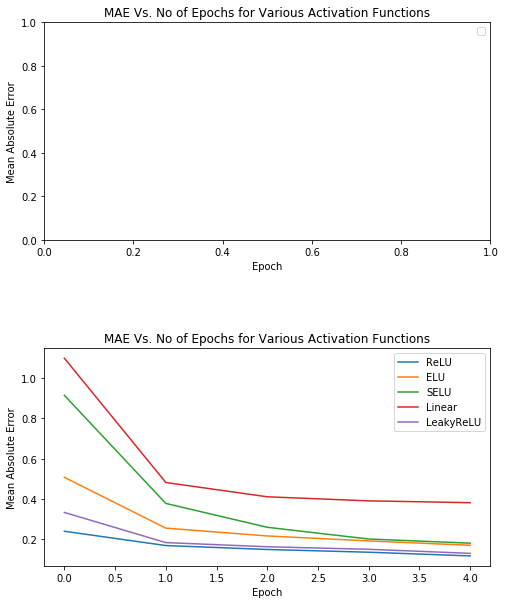

In [22]:
def plot_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    #axes[0].plot(history4.history[metric])
    #axes[0].plot(history5.history[metric])
    #axes[0].plot(history6.history[metric])
    try:
      #axes[0].plot(history.history['val_'+metric])
      #axes[0].plot(history2.history['val2_'+metric])
      #axes[0].plot(history3.history['val3_'+metric])
      axes[0].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')
    except:
      pass
    axes[0].set_title('MAE Vs. No of Epochs for Various Activation Functions')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    axes[1].plot(history2.history['loss'])
    axes[1].plot(history3.history['loss'])
    axes[1].plot(history4.history['loss'])
    axes[1].plot(history5.history['loss'])
    #axes[1].plot(history6.history['loss'])
    try:
      #axes[1].plot(history.history['val_loss'])
      axes[1].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')
    except:
      pass
    axes[1].set_title('MAE Vs. No of Epochs for Various Activation Functions')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(descriptor_history_relu, descriptor_history_elu, descriptor_history_selu, descriptor_history_lin, descriptor_history_lrelu, 'mean_absolute_error')

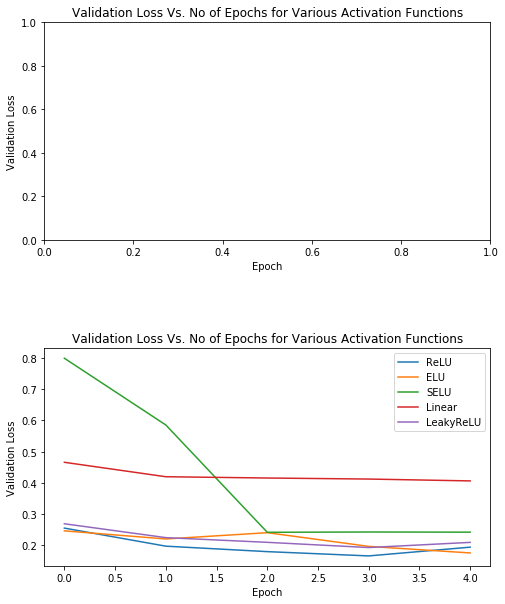

In [21]:
def plot_val_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].plot(history2.history['val_'+metric])
      axes[0].plot(history3.history['val_'+metric])
      axes[0].plot(history4.history['val_'+metric])
      axes[0].plot(history5.history['val_'+metric])
      #axes[0].plot(history6.history['val_'+metric])
      axes[0].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')

    except:
      pass
    axes[0].set_title('Validation Loss Vs. No of Epochs for Various Activation Functions')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    #axes[1].plot(history.history['loss'])
    #axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].plot(history2.history['val_loss'])
      axes[1].plot(history3.history['val_loss'])
      axes[1].plot(history4.history['val_loss'])
      axes[1].plot(history5.history['val_loss'])
      #axes[1].plot(history6.history['val_loss'])
      axes[1].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')

    except:
      pass
    axes[1].set_title('Validation Loss Vs. No of Epochs for Various Activation Functions')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_val_history(descriptor_history_relu, descriptor_history_elu, descriptor_history_selu, descriptor_history_lin, descriptor_history_lrelu, 'mean_absolute_error')